In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns=100
import plotly.graph_objects as go
import plotly.express as px
agentsFile = 'AgentsTimeSeries_Results_april12_1435.xlsx'
colorFile ='colors_dict_April_13_2021.xlsx'

In [2]:
incomeDict = {'Low':9000,'Medium':19500,'High':1000000}
Age = {'Under 65':65,
      'Above 65':65}
gridBG = '#f2f2f2'

In [3]:
res_df = pd.read_excel(agentsFile)

In [4]:
colorExcel = pd.read_excel(colorFile)

In [5]:
res_df.head()

Unnamed: 0 bldCode  doorIndex bldCodeDoorIndex ProjNumber  aprtmentSize  \
0           0  210_19          1         210_19_1   20180988            70   
1           1  210_19          2         210_19_2   20180988            70   
2           2  210_19          3         210_19_3   20180988            70   
3           3  210_19          4         210_19_4   20180988            70   
4           4  210_19          5         210_19_5   20180988            70   

   yearsInBldg  age  lowDiscount  highDiscount  noDiscount   income  rent  \
0           32   19            0             1           0   5145.0     0   
1           30   67            0             0           1  13088.0     0   
2           16   38            0             0           1  15361.0     0   
3            6   16            0             1           0   5428.0     0   
4           17   61            0             0           1  12282.0     1   

   own                               agentID  prjectType  tic status  Floors  \
0    1  2a6d0426-9b6a-11eb-ab03-acde48001122           0    0   stay     NaN   
1    1  2a6d04ee-9b6a-11eb-ab03-acde48001122           0    0   stay     NaN   
2    1  2a6d052a-9b6a-11eb-ab03-acde48001122           0    0   stay     NaN   
3    1  2a6d0566-9b6a-11eb-ab03-acde48001122           0    0   stay     NaN   
4    0  2a6d058e-9b6a-11eb-ab03-acde48001122           0    0   stay     NaN   

   MainCost  cityTax  CostForStaying  ratioCostForStaying reason_leave  \
0       NaN      NaN             NaN                  NaN          NaN   
1       NaN      NaN             NaN                  NaN          NaN   
2       NaN      NaN             NaN                  NaN          NaN   
3       NaN      NaN             NaN                  NaN          NaN   
4       NaN      NaN             NaN                  NaN          NaN   

   mortgage  rentPrice  
0         0        0.0  
1         0        0.0  
2         0        0.0  
3         0        0.0  
4         0        0.0

In [6]:
res_df['stay'] = 0
res_df['stay'] = res_df['status'].apply(lambda x: 1 if x=='stay' else 0)
res_df['leave'] = 0
res_df['leave'] = res_df['status'].apply(lambda x: 1 if x=='leave' else 0)
res_df['New Comers'] = 0
res_df['New Comers'] = res_df['status'].apply(lambda x: 1 if x=='New Comers' else 0)
res_df.fillna(0,inplace=True)
res_df['Under 65'] = 0
res_df['Above 65'] = 0
res_df['Low Income'] = 0
res_df['Medium Income'] = 0
res_df['High Income'] = 0

res_df['Under 65'] = res_df['age'].apply(lambda x: 1 if x<65 else 0)
res_df['Above 65'] = res_df['age'].apply(lambda x: 1 if x>=65 else 0)
res_df['Low Income'] = res_df['income'].apply(lambda x: 1 if (x<incomeDict['Low'])   else 0)
res_df['Medium Income'] = res_df['income'].apply(lambda x: 1 if (x>=incomeDict['Low']) & (x<incomeDict['Medium'])  else 0)
res_df['High Income'] =  res_df['income'].apply(lambda x: 1 if (x>=incomeDict['Medium'])  else 0)
cols_keep=['aprtmentSize','ProjNumber','yearsInBldg','age','rent','own','agentID','prjectType','tic','status','CostForStaying','rentPrice','stay','leave','New Comers','Under 65','Above 65','Low Income','Medium Income','High Income']
cols_stat=['aprtmentSizeMean','ProjNumber','yearsInBldgMean','aprtmentSizeMeanStay','aprtmentSizeNewComer','AgeMean','AgeMeanNew','AgeMeanStay','AgeMeanLeave','AgeOldStayNew','AgeYoungStayNew','AgeOldStay','AgeYoungStay','AgeOldNew','AgeYoungNew','IncomeMean','IncomeMeanStay','IncomeMeanNew','IncomeMeanLeave','IncomeHighStay','IncomeMedStay','IncomeLowStay','IncomeHighNew','IncomeMedNew','IncomeLowNew','IncomeHighStayNew','IncomeMedStayNew','IncomeLowStayNew','meanIncomeStay','meanIncomeNewComers','meanIncomeStay_N_new','rentCount','ownCount','rentStayCount','rentNewCount','ownStayCount','ownNewCount','TotalAgentsCount','prjectType','tic','stay','new comers','CostForStaying','rentPrice']
simAggStat = pd.DataFrame(columns=cols_stat)
ticList = res_df['tic'].unique()
removeList = []
for tic in ticList:
    print('tic',tic)
    projType = res_df[res_df['tic'] ==tic]['prjectType'].iloc[0]
    if tic==0:
        subset = res_df[res_df['tic'] ==tic][cols_keep].copy()
        subset_notLeave = subset[subset['status'].isin(['stay','New Comers'])].copy()
        subset_leave = subset[subset['status'].isin(['leave'])].copy()
        agg_0 = subset_notLeave.agg({'aprtmentSize':'mean','yearsInBldg':'mean','age':'mean','rent':'sum','own':'sum','agentID':'count','rentPrice':'mean','stay':'sum'})
        agg_0_leave = subset_leave.agg({'leave':'count'})
        simAggStat.loc[tic,['aprtmentSizeMean','yearsInBldgMean','AgeMean','rentCount','ownCount','TotalAgentsCount','rentPrice','stay']]=agg_0.to_frame().transpose().values
        simAggStat.loc[tic,'leave'] = agg_0_leave[0]
    else:

        projNumber = res_df[res_df['tic'] ==tic]['ProjNumber'].iloc[0]
        removeList.append(projNumber)        
        print('projNumber',projNumber)
        subset_step1 = res_df[(res_df['tic']<=tic)].copy() # Grab all the agents from tic and below
        subset_step2 = subset_step1[((subset_step1['tic']==0) & (~subset_step1['ProjNumber'].isin(removeList))) | (subset_step1['tic']>0)] # Remove the project from zero
        #subset = res_df[ (((res_df['tic']<=tic) & (res_df['tic']>0)) |  ((res_df['tic']==0) & (~res_df['ProjNumber'].isin(removeList))))]
        subset_notLeave = subset_step2[subset_step2['status'].isin(['stay','New Comers'])].copy()
        subset_stay = subset_notLeave[subset_notLeave['stay']==1].copy()
        subset_newcomers = subset_notLeave[subset_notLeave['New Comers']==1].copy()
        subset_leave = subset_step2[subset_step2['leave']==1].copy()
        agg_All = subset_notLeave.agg({'aprtmentSize':'mean','yearsInBldg':'mean','age':'mean','rent':'sum','own':'sum','agentID':'count','rentPrice':'mean','stay':'sum','New Comers':'sum','CostForStaying':'mean','Under 65':'sum','Above 65':'sum','Low Income':'sum','Medium Income':'sum','High Income':'sum','income':'mean'})
        agg_Stay      =      subset_stay.agg({'aprtmentSize':'mean','age':'mean','rent':'sum','own':'sum','Under 65':'sum','Above 65':'sum','Low Income':'sum','Medium Income':'sum','High Income':'sum','income':'mean'})
        agg_NewComers = subset_newcomers.agg({'aprtmentSize':'mean','age':'mean','rent':'sum','own':'sum','Under 65':'sum','Above 65':'sum','Low Income':'sum','Medium Income':'sum','High Income':'sum','income':'mean'})
        agg_leave = subset_leave.agg({'leave':'count'})
        simAggStat.loc[tic,['aprtmentSizeMean','yearsInBldgMean','AgeMean','rentCount','ownCount','TotalAgentsCount','rentPrice','stay','new comers','CostForStaying','AgeYoungStayNew','AgeOldStayNew','IncomeLowStayNew','IncomeMedStayNew','IncomeHighStayNew','meanIncomeStay_N_new']]=agg_All.to_frame().transpose().values[0]
        simAggStat.loc[tic,'leave'] = agg_leave[0]
        simAggStat.loc[tic,['aprtmentSizeMeanStay','AgeMeanStay','rentStayCount','ownStayCount','AgeYoungStay','AgeOldStay','IncomeLowStay','IncomeMedStay','IncomeHighStay','meanIncomeStay']] = agg_Stay.to_frame().transpose().values[0]
        simAggStat.loc[tic,['aprtmentSizeNewComer','AgeMeanNew','rentNewCount','ownNewCount','AgeYoungNew','AgeOldNew','IncomeLowNew','IncomeMedNew','IncomeHighNew','meanIncomeNewComers']]  = agg_NewComers.to_frame().transpose().values[0]
        simAggStat.loc[tic,'ProjNumber'] = projNumber
    simAggStat.loc[tic,'tic']=tic
    simAggStat.loc[tic,'prjectType']=projType

    

tic 0
tic 1
projNumber 20180988
tic 2
projNumber 20100133
tic 3
projNumber 20180812
tic 4
projNumber 20181092
tic 5
projNumber 20171974
tic 6
projNumber 20180345
tic 7
projNumber 20140556
tic 8
projNumber 20170076
tic 9
projNumber 502-0196659
tic 10
projNumber 20150857
tic 12
projNumber 20140231
tic 13
projNumber 20150274
tic 14
projNumber 20120894
tic 15
projNumber 20181295
tic 16
projNumber 20140060
tic 17
projNumber 20110270
tic 18
projNumber 20140467
tic 19
projNumber 20160319
tic 20
projNumber 20141182
tic 21
projNumber 502-0654715
tic 22
projNumber 502-0316752
tic 23
projNumber 502-0201483
tic 24
projNumber 502-0583948
tic 25
projNumber 502-0424911
tic 26
projNumber 502-0147678
tic 27
projNumber 502-0178285
tic 28
projNumber 502-0317495
tic 29
projNumber 502-0189720
tic 30
projNumber 502-0316588
tic 31
projNumber 20180845
tic 32
projNumber 502-0368860


In [11]:
simAggStat.tail()

aprtmentSizeMean   ProjNumber yearsInBldgMean aprtmentSizeMeanStay  \
28        98.080758  502-0317495         2.27177            86.657343   
29        97.825075  502-0189720        2.009644            89.018939   
30        97.927957  502-0316588        1.716927            92.568376   
31         98.01206     20180845        1.619803            93.401826   
32        98.669434  502-0368860        1.412669            94.830769   

   aprtmentSizeNewComer    AgeMean AgeMeanNew AgeMeanStay AgeMeanLeave  \
28            99.355972  46.845506  47.303669   42.741259          NaN   
29            98.672621  46.715996  47.175355   41.943182          NaN   
30            98.359972  46.916799  47.347227   41.576923          NaN   
31            98.356412  46.897175  47.337653        41.0          NaN   
32            98.914295  46.845018  47.315996   39.461538          NaN   

   AgeOldStayNew AgeYoungStayNew AgeOldStay AgeYoungStay AgeOldNew  \
28         560.0          2288.0       41.0        245.0     519.0   
29         583.0          2424.0       33.0        231.0     550.0   
30         613.0          2524.0       25.0        209.0     588.0   
31         617.0          2534.0       20.0        199.0     597.0   
32         634.0          2618.0       11.0        184.0     623.0   

   AgeYoungNew IncomeMean IncomeMeanStay IncomeMeanNew IncomeMeanLeave  \
28      2043.0        NaN            NaN           NaN             NaN   
29      2193.0        NaN            NaN           NaN             NaN   
30      2315.0        NaN            NaN           NaN             NaN   
31      2335.0        NaN            NaN           NaN             NaN   
32      2434.0        NaN            NaN           NaN             NaN   

   IncomeHighStay IncomeMedStay IncomeLowStay IncomeHighNew IncomeMedNew  \
28            0.0         165.0         121.0        2323.0        239.0   
29            0.0         155.0         109.0        2497.0        246.0   
30            0.0         141.0          93.0        2655.0        248.0   
31            0.0         130.0          89.0        2684.0        248.0   
32            0.0         116.0          79.0        2809.0        248.0   

   IncomeLowNew IncomeHighStayNew IncomeMedStayNew IncomeLowStayNew  \
28          0.0            2323.0            404.0            121.0   
29          0.0            2497.0            401.0            109.0   
30          0.0            2655.0            389.0             93.0   
31          0.0            2684.0            378.0             89.0   
32          0.0            2809.0            364.0             79.0   

   meanIncomeStay meanIncomeNewComers meanIncomeStay_N_new rentCount ownCount  \
28    8107.164336        23968.171987         22375.388213     938.0   1910.0   
29     8183.94697        23820.723133         22447.890107     985.0   2022.0   
30    8231.047009        23752.924389         22595.092286    1026.0   2111.0   
31    8066.378995        23747.390115         22657.532471    1031.0   2120.0   
32    7884.184615        23864.878217         22906.626295    1068.0   2184.0   

   rentStayCount rentNewCount ownStayCount ownNewCount TotalAgentsCount  \
28          30.0        908.0        256.0      1654.0           2848.0   
29          18.0        967.0        246.0      1776.0           3007.0   
30          10.0       1016.0        224.0      1887.0           3137.0   
31           4.0       1027.0        215.0      1905.0           3151.0   
32           0.0       1068.0        195.0      1989.0           3252.0   

   prjectType tic   stay new comers CostForStaying rentPrice  leave  
28          3  28  286.0     2562.0    7395.747897       0.0  611.0  
29          3  29  264.0     2743.0    7450.024353       0.0  633.0  
30          3  30  234.0     2903.0    7535.015158       0.0  663.0  
31          1  31  219.0     2932.0    7576.772323       0.0  678.0  
32          3  32  195.0     3057.0    7697.620354       0.0  702.0

<AxesSubplot:>

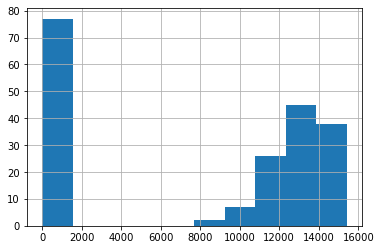

In [12]:
res_df[(res_df['tic']>0) & (res_df['status']=='stay')]['income'].hist()

<AxesSubplot:>

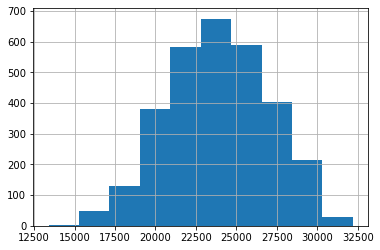

In [13]:
res_df.query('tic>0 & status=="New Comers"')['income'].hist()
#.groupby(['tic','status']).agg({'Low Income':'sum','Medium Income':'sum','High Income':'sum'})

In [14]:
res2 = simAggStat.loc[1:].copy()
res2 = res2[res2.columns[res2.notnull().loc[1].values]].copy()

## Need to add 
* Age of new comers and staying and leaving
* Income of New comers and staying and leaving
* Age Group of new comers and staying and leaving
* Income Group of new comers and staying

In [20]:
stayingC = colorExcel.query('label=="Staying"')['colors_'].values[0]
leavingC = colorExcel.query('label=="Leaving"')['colors_'].values[0]
newComerC = colorExcel.query('label=="New Comers"')['colors_'].values[0]
aC = colorExcel.query('label=="Addition"')['colors_'].values[0]
rC = colorExcel.query('label=="Reconstruction"')['colors_'].values[0]
rrC = colorExcel.query('label=="Raze and Rebuild"')['colors_'].values[0]
totalPopC = colorExcel.query('label=="Total Pop"')['colors_'].values[0]

lowIncomeC = colorExcel.loc[colorExcel['label']=='Moderate','colors_'].values[0]
medIncomeC = colorExcel.loc[colorExcel['label']=='Middle','colors_'].values[0]
upIncomeC = colorExcel.loc[colorExcel['label']=='Upper','colors_'].values[0]

widthD=900
heightD=600


res2.loc[res2['prjectType']==1,'Project Type '] = 'Addition'
res2.loc[res2['prjectType']==2,'Project Type '] = 'Reconstruction'
res2.loc[res2['prjectType']==3,'Project Type '] = 'Raze and Rebuild'
res2['y_shift'] =-20
# Change the bar mode
aTics = res2.loc[res2['prjectType'] == 1, 'tic']
aYshift =res2.loc[res2['prjectType'] == 1, 'y_shift']

rTics = res2.loc[res2['prjectType'] == 2, 'tic']
rYshift = res2.loc[res2['prjectType'] == 2, 'y_shift']

rrTics = res2.loc[res2['prjectType'] == 3, 'tic']
rrYshift = res2.loc[res2['prjectType'] == 3, 'y_shift']


In [21]:
titlesList = ['Staying','New Comers','Total (Staying+New Comers)']
colList = ['stay','new comers','TotalAgentsCount']
colorList = [stayingC,newComerC,totalPopC]
styleList = [dict(color=stayingC, width=4), dict(color=newComerC, width=4), dict(color=totalPopC, dash='dash')] 
genericGraph = res2.copy()

In [22]:
genericGraph.head()

aprtmentSizeMean ProjNumber yearsInBldgMean aprtmentSizeMeanStay  \
1        75.337691   20180988        23.67756            75.089266   
2        75.616379   20100133       23.007543            75.190805   
3        75.587302   20180812       22.314286            75.660819   
4        76.027112   20181092       21.590198            75.655991   
5        76.627907   20171974       20.691608            75.944844   

  aprtmentSizeNewComer    AgeMean AgeMeanNew AgeMeanStay AgeOldStayNew  \
1                 82.0  47.220044  48.787879   47.161582         238.0   
2                 82.0  47.143319  48.844828   47.029885         237.0   
3            74.888889  47.248677       49.1   47.053801         242.0   
4            78.724138  47.117831  48.577586   46.916963         242.0   
5            80.303226  47.193124  49.187097   46.822542         250.0   

  AgeYoungStayNew AgeOldStay AgeYoungStay AgeOldNew AgeYoungNew  \
1           680.0      230.0        655.0       8.0        25.0   
2           691.0      224.0        646.0      13.0        45.0   
3           703.0      220.0        635.0      22.0        68.0   
4           717.0      214.0        629.0      28.0        88.0   
5           739.0      211.0        623.0      39.0       116.0   

  IncomeHighStay IncomeMedStay IncomeLowStay IncomeHighNew IncomeMedNew  \
1            0.0         377.0         508.0          22.0         11.0   
2            0.0         374.0         496.0          36.0         22.0   
3            0.0         365.0         490.0          36.0         54.0   
4            0.0         360.0         483.0          60.0         56.0   
5            0.0         356.0         478.0          91.0         64.0   

  IncomeLowNew IncomeHighStayNew IncomeMedStayNew IncomeLowStayNew  \
1          0.0              22.0            388.0            508.0   
2          0.0              36.0            396.0            496.0   
3          0.0              36.0            419.0            490.0   
4          0.0              60.0            416.0            483.0   
5          0.0              91.0            420.0            478.0   

  meanIncomeStay meanIncomeNewComers meanIncomeStay_N_new rentCount ownCount  \
1    7626.976271         20161.14673          8077.551026     321.0    597.0   
2    7622.918391         20302.00363          8415.361218     326.0    602.0   
3    7587.665497        18955.571345          8670.323197     327.0    618.0   
4    7576.147094         19680.70735          9040.306624     331.0    628.0   
5    7557.907674        19907.799151          9493.431616     344.0    645.0   

  rentStayCount rentNewCount ownStayCount ownNewCount TotalAgentsCount  \
1         310.0         11.0        575.0        22.0            918.0   
2         304.0         22.0        566.0        36.0            928.0   
3         297.0         30.0        558.0        60.0            945.0   
4         291.0         40.0        552.0        76.0            959.0   
5         286.0         58.0        548.0        97.0            989.0   

  prjectType tic   stay new comers CostForStaying rentPrice  leave  \
1          1   1  885.0       33.0     248.878715       0.0   12.0   
2          1   2  870.0       58.0      427.65347       0.0   27.0   
3          1   3  855.0       90.0     597.379746       0.0   42.0   
4          1   4  843.0      116.0     795.139374       0.0   54.0   
5          2   5  834.0      155.0    1050.745511       0.0   63.0   

    Project Type   y_shift  
1        Addition      -20  
2        Addition      -20  
3        Addition      -20  
4        Addition      -20  
5  Reconstruction      -20

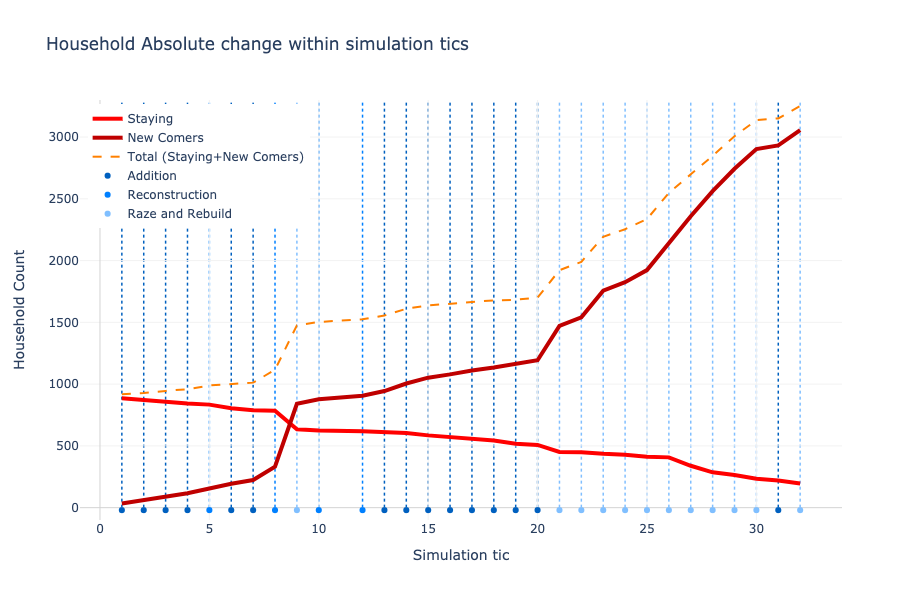

In [23]:

fig = go.Figure()
for i in range(3):
    fig.add_trace(go.Scatter(
        x=genericGraph['tic'],
        y=genericGraph[colList[i]],
        line=styleList[i],
        name=titlesList[i]
    ))
 

maxY=3300
for xtic in aTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY, line=dict(
        color=aC, width=1.5, dash="dot"), layer="below")

for xtic in rTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY, line=dict(
        color=rC, width=1.5, dash="dot"), layer="below")

for xtic in rrTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY,
                  line=dict(color=rrC, width=1.5, dash="dot"), layer="below")

    
fig.add_trace(go.Scatter(name='Addition', x=aTics, y=aYshift,
                         mode='markers', marker=dict(color=aC)))
fig.add_trace(go.Scatter(name='Reconstruction', x=rTics, y=rYshift,
                         mode='markers', marker=dict(color=rC)))
fig.add_trace(go.Scatter(name='Raze and Rebuild', x=rrTics,
                         y=rrYshift, mode='markers', marker=dict(color=rrC)))

fig.update_layout(width=widthD,height=heightD, title='Household Absolute change within simulation tics')
fig.update_yaxes(title='Household Count',range=[-100, maxY],gridwidth=1, gridcolor=gridBG,zerolinewidth=1,zerolinecolor='lightgrey')
fig.update_xaxes(title='Simulation tic',gridwidth=1, gridcolor=gridBG,zerolinewidth=1,zerolinecolor='lightgrey')
fig.update_layout(showlegend=True,plot_bgcolor='rgba(0,0,0,0)',legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))
fig.show()

# Economic

In [25]:
titlesList = ['Staying','New Comers','Average (Staying+New Comers)']
title_ ='Average Income Staying Vs New Comers'
y_title = 'Income in New Israeli Shekel'
colList = ['meanIncomeStay','meanIncomeNewComers','meanIncomeStay_N_new']
colorList = [stayingC,newComerC,totalPopC]
styleList = [dict(color=stayingC, width=4), dict(color=newComerC, width=4), dict(color=totalPopC, dash='dash')] 
genericGraph = res2.copy()
genericGraph['y_shift'] =5000
# Change the bar mode
aYshift =genericGraph.loc[genericGraph['prjectType'] == 1, 'y_shift']
rYshift = genericGraph.loc[genericGraph['prjectType'] == 2, 'y_shift']
rrYshift = genericGraph.loc[genericGraph['prjectType'] == 3, 'y_shift']

In [26]:
res2.head()

aprtmentSizeMean ProjNumber yearsInBldgMean aprtmentSizeMeanStay  \
1        75.337691   20180988        23.67756            75.089266   
2        75.616379   20100133       23.007543            75.190805   
3        75.587302   20180812       22.314286            75.660819   
4        76.027112   20181092       21.590198            75.655991   
5        76.627907   20171974       20.691608            75.944844   

  aprtmentSizeNewComer    AgeMean AgeMeanNew AgeMeanStay AgeOldStayNew  \
1                 82.0  47.220044  48.787879   47.161582         238.0   
2                 82.0  47.143319  48.844828   47.029885         237.0   
3            74.888889  47.248677       49.1   47.053801         242.0   
4            78.724138  47.117831  48.577586   46.916963         242.0   
5            80.303226  47.193124  49.187097   46.822542         250.0   

  AgeYoungStayNew AgeOldStay AgeYoungStay AgeOldNew AgeYoungNew  \
1           680.0      230.0        655.0       8.0        25.0   
2           691.0      224.0        646.0      13.0        45.0   
3           703.0      220.0        635.0      22.0        68.0   
4           717.0      214.0        629.0      28.0        88.0   
5           739.0      211.0        623.0      39.0       116.0   

  IncomeHighStay IncomeMedStay IncomeLowStay IncomeHighNew IncomeMedNew  \
1            0.0         377.0         508.0          22.0         11.0   
2            0.0         374.0         496.0          36.0         22.0   
3            0.0         365.0         490.0          36.0         54.0   
4            0.0         360.0         483.0          60.0         56.0   
5            0.0         356.0         478.0          91.0         64.0   

  IncomeLowNew IncomeHighStayNew IncomeMedStayNew IncomeLowStayNew  \
1          0.0              22.0            388.0            508.0   
2          0.0              36.0            396.0            496.0   
3          0.0              36.0            419.0            490.0   
4          0.0              60.0            416.0            483.0   
5          0.0              91.0            420.0            478.0   

  meanIncomeStay meanIncomeNewComers meanIncomeStay_N_new rentCount ownCount  \
1    7626.976271         20161.14673          8077.551026     321.0    597.0   
2    7622.918391         20302.00363          8415.361218     326.0    602.0   
3    7587.665497        18955.571345          8670.323197     327.0    618.0   
4    7576.147094         19680.70735          9040.306624     331.0    628.0   
5    7557.907674        19907.799151          9493.431616     344.0    645.0   

  rentStayCount rentNewCount ownStayCount ownNewCount TotalAgentsCount  \
1         310.0         11.0        575.0        22.0            918.0   
2         304.0         22.0        566.0        36.0            928.0   
3         297.0         30.0        558.0        60.0            945.0   
4         291.0         40.0        552.0        76.0            959.0   
5         286.0         58.0        548.0        97.0            989.0   

  prjectType tic   stay new comers CostForStaying rentPrice  leave  \
1          1   1  885.0       33.0     248.878715       0.0   12.0   
2          1   2  870.0       58.0      427.65347       0.0   27.0   
3          1   3  855.0       90.0     597.379746       0.0   42.0   
4          1   4  843.0      116.0     795.139374       0.0   54.0   
5          2   5  834.0      155.0    1050.745511       0.0   63.0   

    Project Type   y_shift  
1        Addition      -20  
2        Addition      -20  
3        Addition      -20  
4        Addition      -20  
5  Reconstruction      -20

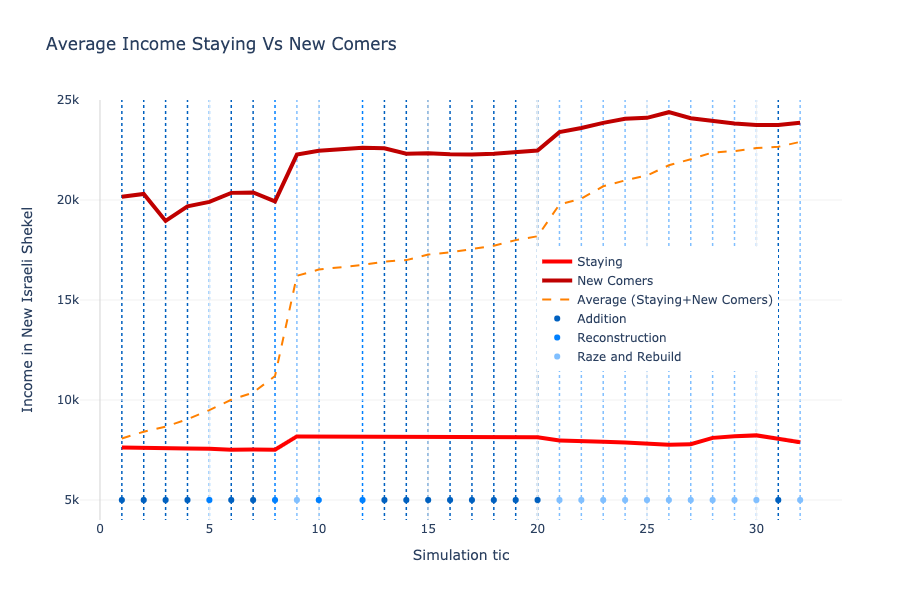

In [27]:

fig = go.Figure()
for i in range(3):
    fig.add_trace(go.Scatter(
        x=genericGraph['tic'],
        y=genericGraph[colList[i]],
        line=styleList[i],
        name=titlesList[i]
    ))
 

maxY=25000
for xtic in aTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY, line=dict(
        color=aC, width=1.5, dash="dot"), layer="below")

for xtic in rTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY, line=dict(
        color=rC, width=1.5, dash="dot"), layer="below")

for xtic in rrTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY,
                  line=dict(color=rrC, width=1.5, dash="dot"), layer="below")

    
fig.add_trace(go.Scatter(name='Addition', x=aTics, y=aYshift,
                         mode='markers', marker=dict(color=aC)))
fig.add_trace(go.Scatter(name='Reconstruction', x=rTics, y=rYshift,
                         mode='markers', marker=dict(color=rC)))
fig.add_trace(go.Scatter(name='Raze and Rebuild', x=rrTics,
                         y=rrYshift, mode='markers', marker=dict(color=rrC)))

fig.update_layout(width=widthD,height=heightD, title=title_)
fig.update_yaxes(title=y_title,range=[4000, maxY],gridwidth=1, gridcolor=gridBG,zerolinewidth=1,zerolinecolor='lightgrey')
fig.update_xaxes(title='Simulation tic',gridwidth=1, gridcolor=gridBG,zerolinewidth=1,zerolinecolor='lightgrey')
fig.update_layout(showlegend=True,plot_bgcolor='rgba(0,0,0,0)',legend=dict(yanchor="top", y=0.65, xanchor="left", x=0.6))
fig.show()

In [28]:
genericGraph = res2.copy()
title_ ='Percent Income by Group Staying Vs New Comers'
y_title = 'Household Percent'
lowIncomeC = colorExcel.loc[colorExcel['label']=='Moderate','colors_'].values[0]
medIncomeC = colorExcel.loc[colorExcel['label']=='Middle','colors_'].values[0]
upIncomeC = colorExcel.loc[colorExcel['label']=='Upper','colors_'].values[0]
#totalPopC
columnsList = ['IncomeHighStay','IncomeMedStay','IncomeLowStay','IncomeHighNew','IncomeMedNew','IncomeLowNew','IncomeHighStayNew','IncomeMedStayNew','IncomeLowStayNew']
titlesList = ['High Stay','Med Stay','Low Stay','High New Comer','Med New Comer','Low New Comer','High (average)','Medium (average)','Low (average)']
legendGroup =['Staying','Staying','Staying','New Comers','New Comers','New Comers','Average','Average','Average']
styleList = [dict(color=upIncomeC,width=2),
             dict(color=medIncomeC,width=2),
             dict(color=lowIncomeC,width=2),
             dict(color=upIncomeC,width=4),
             dict(color=medIncomeC,width=4),
             dict(color=lowIncomeC,width=4),
             dict(color='hsv(30,50%,100%)',dash='dash'),
             dict(color='hsv(30,75%,100%)', dash='dash'),
             dict(color='hsv(30,100%,50%)', dash='dash')]
percentList=[]
for i in range(9):
    percentList.append(f'{columnsList[i]}Percent')
    genericGraph[percentList[i]] = genericGraph[columnsList[i]]/genericGraph['TotalAgentsCount']
genericGraph['y_shift'] =-0.02
# Change the bar mode
aYshift =genericGraph.loc[genericGraph['prjectType'] == 1, 'y_shift']
rYshift = genericGraph.loc[genericGraph['prjectType'] == 2, 'y_shift']
rrYshift = genericGraph.loc[genericGraph['prjectType'] == 3, 'y_shift']

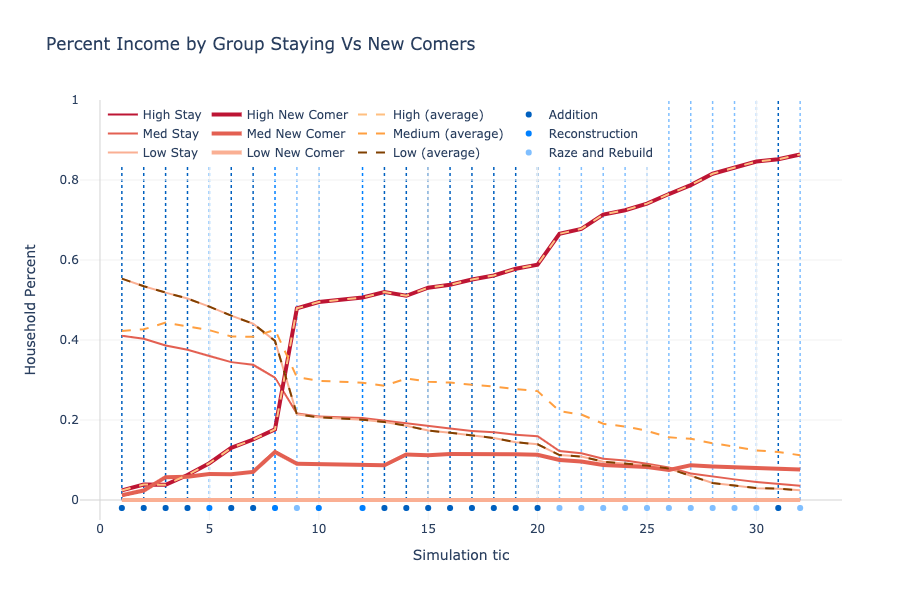

In [29]:
maxY=1
fig = go.Figure()
for i in range(9):
    fig.add_trace(go.Scatter(
        x=genericGraph['tic'],
        y=genericGraph[percentList[i]],
        legendgroup = legendGroup[i],
        line=styleList[i],
        name=titlesList[i]
    ))
for xtic in aTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY, line=dict(
        color=aC, width=1.5, dash="dot"), layer="below")

for xtic in rTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY, line=dict(
        color=rC, width=1.5, dash="dot"), layer="below")

for xtic in rrTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY,
                  line=dict(color=rrC, width=1.5, dash="dot"), layer="below")
    
fig.add_trace(go.Scatter(name='Addition', x=aTics, y=aYshift,
                         mode='markers', legendgroup='Building Type', marker=dict(color=aC)))
fig.add_trace(go.Scatter(name='Reconstruction',legendgroup='Building Type',  x=rTics, y=rYshift,
                         mode='markers', marker=dict(color=rC)))
fig.add_trace(go.Scatter(name='Raze and Rebuild',legendgroup='Building Type',  x=rrTics,
                         y=rrYshift, mode='markers', marker=dict(color=rrC)))

    
fig.update_layout(width=widthD,height=heightD, title=title_)
fig.update_yaxes(title=y_title,range=[-0.05, maxY],gridwidth=1, gridcolor=gridBG,zerolinewidth=1,zerolinecolor='lightgrey')

fig.update_xaxes(title='Simulation tic',gridwidth=1, gridcolor=gridBG,zerolinewidth=1,zerolinecolor='lightgrey')
fig.update_layout(showlegend=True,plot_bgcolor='rgba(0,0,0,0)',legend=dict(orientation='h',yanchor="top", y=1.0, xanchor="left", x=0.03))

fig.show()

In [30]:
genericGraph = res2.copy()
title_ ='Number of Income by Group Staying Vs New Comers'
y_title = 'Household Count'
lowIncomeC = colorExcel.loc[colorExcel['label']=='Moderate','colors_'].values[0]
medIncomeC = colorExcel.loc[colorExcel['label']=='Middle','colors_'].values[0]
upIncomeC = colorExcel.loc[colorExcel['label']=='Upper','colors_'].values[0]
#totalPopC
columnsList = ['IncomeHighStay','IncomeMedStay','IncomeLowStay','IncomeHighNew','IncomeMedNew','IncomeLowNew','IncomeHighStayNew','IncomeMedStayNew','IncomeLowStayNew']
titlesList = ['High Stay','Med Stay','Low Stay','High New Comer','Med New Comer','Low New Comer','High (average)','Medium (average)','Low (average)']
legendGroup =['Staying','Staying','Staying','New Comers','New Comers','New Comers','Average','Average','Average']
styleList = [dict(color=upIncomeC,width=2),
             dict(color=medIncomeC,width=2),
             dict(color=lowIncomeC,width=2),
             dict(color=upIncomeC,width=4),
             dict(color=medIncomeC,width=4),
             dict(color=lowIncomeC,width=4),
             dict(color='hsv(30,50%,100%)',dash='dash'),
             dict(color='hsv(30,75%,100%)', dash='dash'),
             dict(color='hsv(30,100%,50%)', dash='dash')]

genericGraph['y_shift'] =-50
# Change the bar mode
aYshift =genericGraph.loc[genericGraph['prjectType'] == 1, 'y_shift']
rYshift = genericGraph.loc[genericGraph['prjectType'] == 2, 'y_shift']
rrYshift = genericGraph.loc[genericGraph['prjectType'] == 3, 'y_shift']

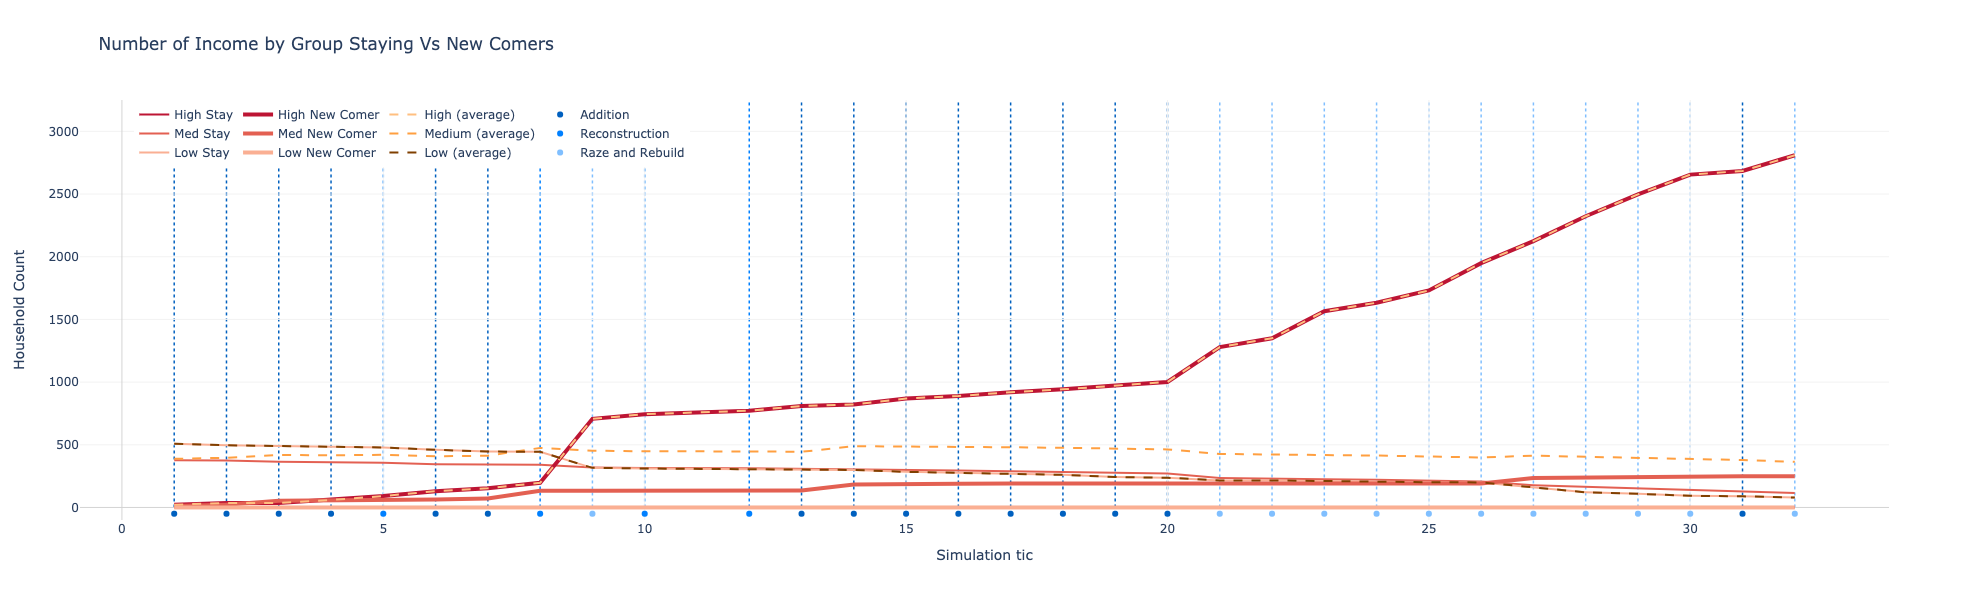

In [31]:
maxY=3250
fig = go.Figure()
for i in range(9):
    fig.add_trace(go.Scatter(
        x=genericGraph['tic'],
        y=genericGraph[columnsList[i]],
        legendgroup = legendGroup[i],
        line=styleList[i],
        name=titlesList[i]
    ))
for xtic in aTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY, line=dict(
        color=aC, width=1.5, dash="dot"), layer="below")

for xtic in rTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY, line=dict(
        color=rC, width=1.5, dash="dot"), layer="below")

for xtic in rrTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY,
                  line=dict(color=rrC, width=1.5, dash="dot"), layer="below")
    
fig.add_trace(go.Scatter(name='Addition', x=aTics, y=aYshift,
                         mode='markers', legendgroup='Building Type', marker=dict(color=aC)))
fig.add_trace(go.Scatter(name='Reconstruction',legendgroup='Building Type',  x=rTics, y=rYshift,
                         mode='markers', marker=dict(color=rC)))
fig.add_trace(go.Scatter(name='Raze and Rebuild',legendgroup='Building Type',  x=rrTics,
                         y=rrYshift, mode='markers', marker=dict(color=rrC)))

    
fig.update_layout(width=widthD,height=heightD, title=title_)
fig.update_yaxes(title=y_title,range=[-100, maxY],gridwidth=1, gridcolor=gridBG,zerolinewidth=1,zerolinecolor='lightgrey')

fig.update_xaxes(title='Simulation tic',gridwidth=1, gridcolor=gridBG,zerolinewidth=1,zerolinecolor='lightgrey')
fig.update_layout(showlegend=True,plot_bgcolor='rgba(0,0,0,0)',legend=dict(orientation='h',yanchor="top", y=1.0, xanchor="left", x=0.03))

fig.show()

# Age Move in move out with Class

In [32]:
genericGraph = res2.copy()
title_ ='Above and Below 65 troughout the simulation'
y_title = 'Household Percent'
above65C = colorExcel.loc[colorExcel['label']=='65-84','colors_'].values[0]
below65C = colorExcel.loc[colorExcel['label']=='18-44','colors_'].values[0]
averageBelowAgeC = colorExcel.loc[colorExcel['label']=='45-64','colors_'].values[0]
averageAboveAgeC = colorExcel.loc[colorExcel['label']=='85+','colors_'].values[0]
#totalPopC
columnsList = ['AgeYoungStay','AgeOldStay','AgeYoungNew','AgeOldNew','AgeYoungStayNew','AgeOldStayNew']
titlesList = ['Under 65 Stay','Above 65 Stay','Under 65 New Comers','Above 65 New Comers','Under 65 (Average)','Above 65 (Average)']
legendGroup =['Staying','Staying','New Comers','New Comers','Average','Average']
styleList = [dict(color=below65C,width=2),
             dict(color=above65C,width=2),
             dict(color=below65C,width=4),
             dict(color=above65C,width=4),
             dict(color=averageBelowAgeC,dash='dash'),
             dict(color=averageAboveAgeC, dash='dash')]
percentList=[]
for i in range(6):
    percentList.append(f'{columnsList[i]}Percent')
    genericGraph[percentList[i]] = genericGraph[columnsList[i]]/genericGraph['TotalAgentsCount']
genericGraph['y_shift'] =-0.02
# Change the bar mode
aYshift =genericGraph.loc[genericGraph['prjectType'] == 1, 'y_shift']
rYshift = genericGraph.loc[genericGraph['prjectType'] == 2, 'y_shift']
rrYshift = genericGraph.loc[genericGraph['prjectType'] == 3, 'y_shift']

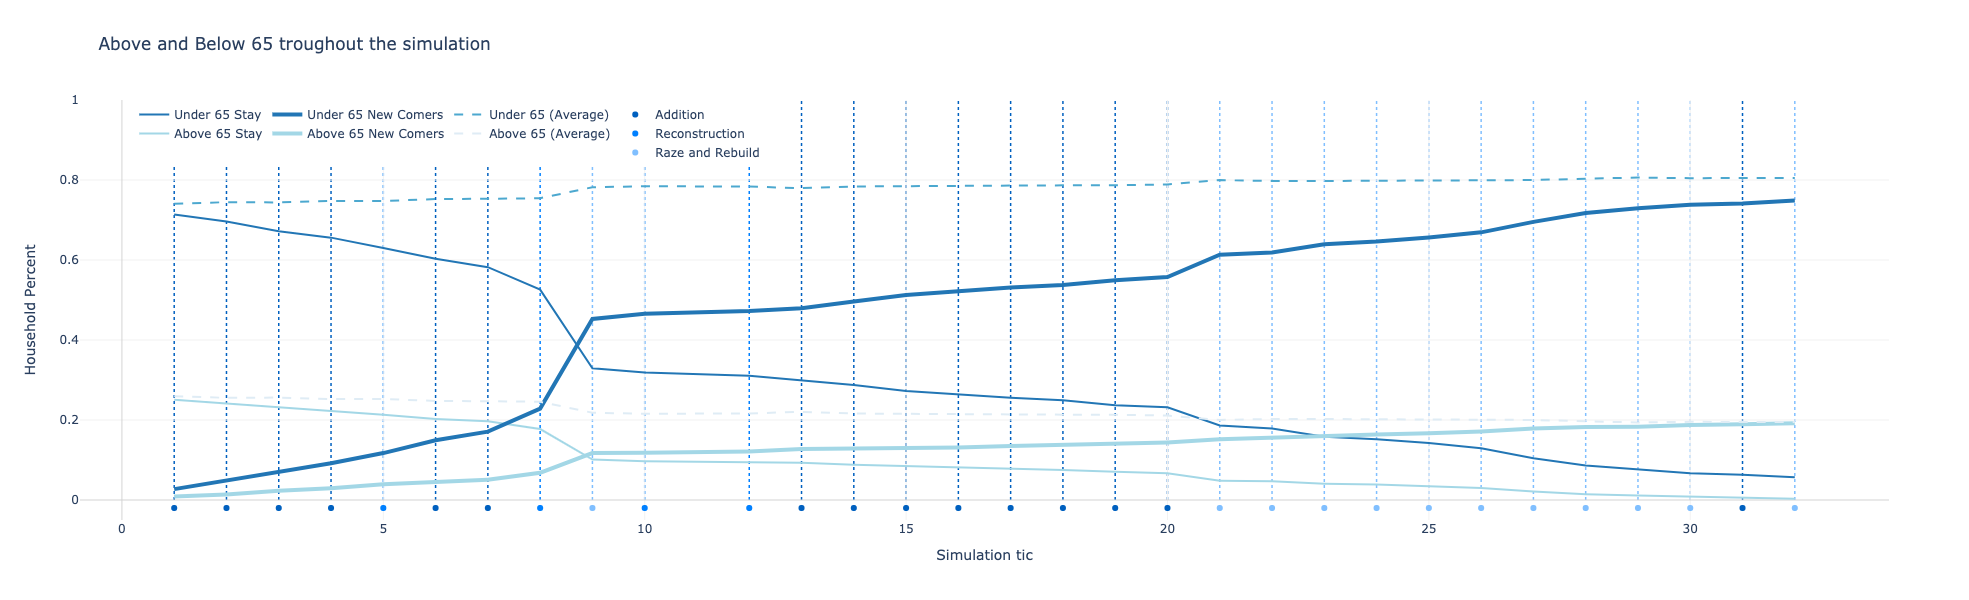

In [33]:
maxY=1
fig = go.Figure()
for i in range(6):
    fig.add_trace(go.Scatter(
        x=genericGraph['tic'],
        y=genericGraph[percentList[i]],
        legendgroup = legendGroup[i],
        line=styleList[i],
        name=titlesList[i]
    ))
for xtic in aTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY, line=dict(
        color=aC, width=1.5, dash="dot"), layer="below")

for xtic in rTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY, line=dict(
        color=rC, width=1.5, dash="dot"), layer="below")

for xtic in rrTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY,
                  line=dict(color=rrC, width=1.5, dash="dot"), layer="below")
    
fig.add_trace(go.Scatter(name='Addition', x=aTics, y=aYshift,
                         mode='markers', legendgroup='Building Type', marker=dict(color=aC)))
fig.add_trace(go.Scatter(name='Reconstruction',legendgroup='Building Type',  x=rTics, y=rYshift,
                         mode='markers', marker=dict(color=rC)))
fig.add_trace(go.Scatter(name='Raze and Rebuild',legendgroup='Building Type',  x=rrTics,
                         y=rrYshift, mode='markers', marker=dict(color=rrC)))

    
fig.update_layout(width=widthD,height=heightD, title=title_)
fig.update_yaxes(title=y_title,range=[-0.05, maxY],gridwidth=1, gridcolor=gridBG,zerolinewidth=1,zerolinecolor='lightgrey')

fig.update_xaxes(title='Simulation tic',gridwidth=1, gridcolor=gridBG,zerolinewidth=1,zerolinecolor='lightgrey')
fig.update_layout(showlegend=True,plot_bgcolor='rgba(0,0,0,0)',legend=dict(orientation='h',yanchor="top", y=1.0, xanchor="left", x=0.03))

fig.show()

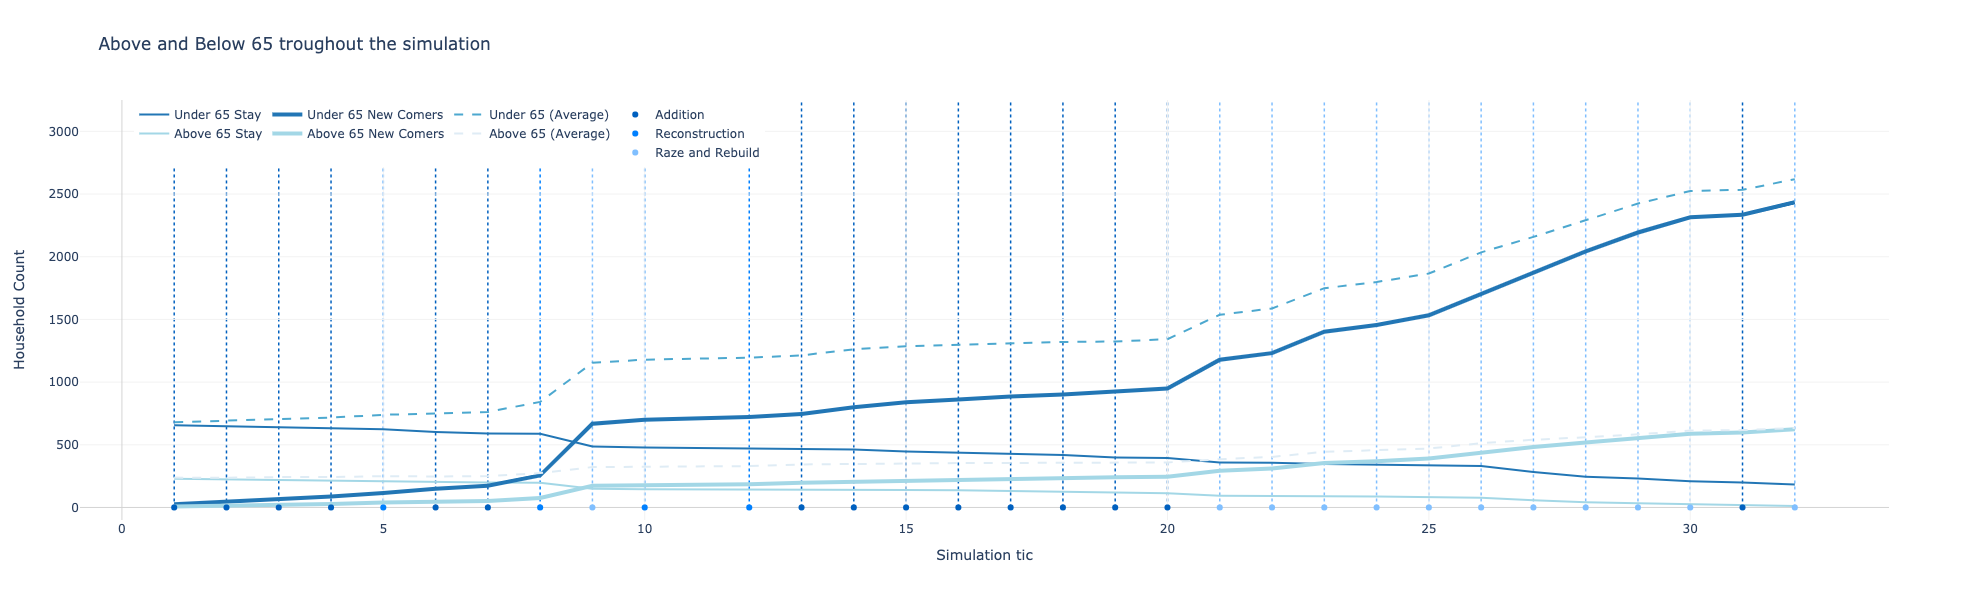

In [34]:
maxY=3250
y_title = 'Household Count'
genericGraph['y_shift'] =-50
fig = go.Figure()
for i in range(6):
    fig.add_trace(go.Scatter(
        x=genericGraph['tic'],
        y=genericGraph[columnsList[i]],
        legendgroup = legendGroup[i],
        line=styleList[i],
        name=titlesList[i]
    ))
for xtic in aTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY, line=dict(
        color=aC, width=1.5, dash="dot"), layer="below")

for xtic in rTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY, line=dict(
        color=rC, width=1.5, dash="dot"), layer="below")

for xtic in rrTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY,
                  line=dict(color=rrC, width=1.5, dash="dot"), layer="below")
    
fig.add_trace(go.Scatter(name='Addition', x=aTics, y=aYshift,
                         mode='markers', legendgroup='Building Type', marker=dict(color=aC)))
fig.add_trace(go.Scatter(name='Reconstruction',legendgroup='Building Type',  x=rTics, y=rYshift,
                         mode='markers', marker=dict(color=rC)))
fig.add_trace(go.Scatter(name='Raze and Rebuild',legendgroup='Building Type',  x=rrTics,
                         y=rrYshift, mode='markers', marker=dict(color=rrC)))

    
fig.update_layout(width=widthD,height=heightD, title=title_)
fig.update_yaxes(title=y_title,range=[-100, maxY],gridwidth=1, gridcolor=gridBG,zerolinewidth=1,zerolinecolor='lightgrey')

fig.update_xaxes(title='Simulation tic',gridwidth=1, gridcolor=gridBG,zerolinewidth=1,zerolinecolor='lightgrey')
fig.update_layout(showlegend=True,plot_bgcolor='rgba(0,0,0,0)',legend=dict(orientation='h',yanchor="top", y=1.0, xanchor="left", x=0.03))

fig.show()

## Apartment Size

In [134]:
title_ ='Apartment Size Change'
y_title = 'Size in Sq Meters'
titlesList = ['Staying','New Comers','Average']
colList = ['aprtmentSizeMeanStay','aprtmentSizeNewComer','aprtmentSizeMean']
colorList = [stayingC,newComerC,totalPopC]
styleList = [dict(color=stayingC, width=4), dict(color=newComerC, width=4), dict(color=totalPopC, dash='dash')] 
genericGraph = res2.copy()
genericGraph['y_shift'] =70
# Change the bar mode
aYshift =genericGraph.loc[genericGraph['prjectType'] == 1, 'y_shift']
rYshift = genericGraph.loc[genericGraph['prjectType'] == 2, 'y_shift']
rrYshift = genericGraph.loc[genericGraph['prjectType'] == 3, 'y_shift']

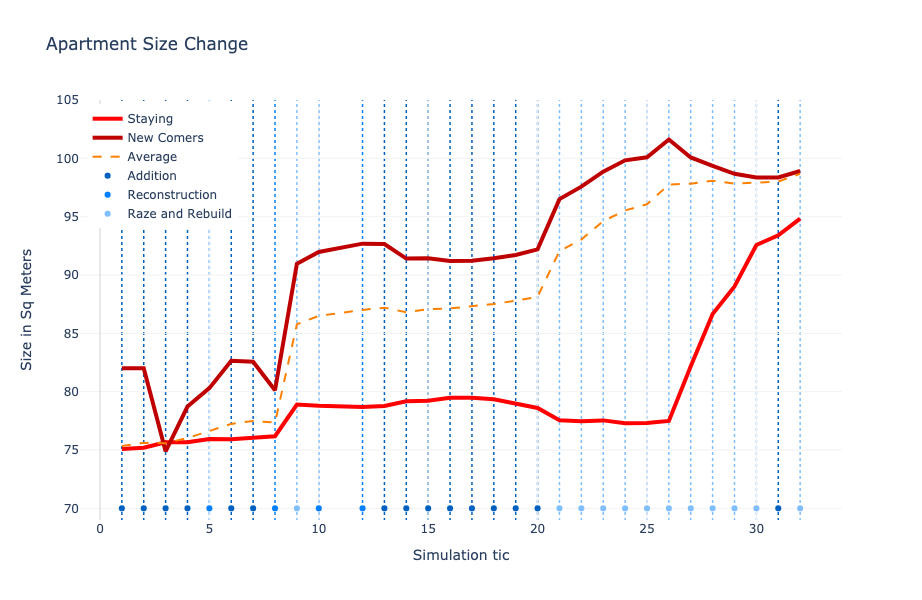

In [137]:

fig = go.Figure()
for i in range(3):
    fig.add_trace(go.Scatter(
        x=genericGraph['tic'],
        y=genericGraph[colList[i]],
        line=styleList[i],
        name=titlesList[i]
    ))
 

maxY=105
for xtic in aTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY, line=dict(
        color=aC, width=1.5, dash="dot"), layer="below")

for xtic in rTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY, line=dict(
        color=rC, width=1.5, dash="dot"), layer="below")

for xtic in rrTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY,
                  line=dict(color=rrC, width=1.5, dash="dot"), layer="below")

    
fig.add_trace(go.Scatter(name='Addition', x=aTics, y=aYshift,
                         mode='markers', marker=dict(color=aC)))
fig.add_trace(go.Scatter(name='Reconstruction', x=rTics, y=rYshift,
                         mode='markers', marker=dict(color=rC)))
fig.add_trace(go.Scatter(name='Raze and Rebuild', x=rrTics,
                         y=rrYshift, mode='markers', marker=dict(color=rrC)))

fig.update_layout(width=widthD,height=heightD, title=title_)
fig.update_yaxes(title=y_title,range=[69, maxY],gridwidth=1, gridcolor=gridBG,zerolinewidth=1,zerolinecolor='lightgrey')
fig.update_xaxes(title='Simulation tic',gridwidth=1, gridcolor=gridBG,zerolinewidth=1,zerolinecolor='lightgrey')
fig.update_layout(showlegend=True,plot_bgcolor='rgba(0,0,0,0)',legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))
fig.show()

# Age Change Move In and Move Out

In [36]:
genericGraph = res2.copy()
title_ ='Average Age Trhoughout the Simulatiom'
y_title = 'Average Age'
#totalPopC
columnsList = ['AgeMeanStay','AgeMeanNew','AgeMean']
titlesList = ['Staying','New Comers','Average']
legendGroup =['Staying','New Comers','Average']
styleList = [dict(color=stayingC,width=2),
             dict(color=newComerC,width=2),
             dict(color=totalPopC,dash='dash')]

genericGraph['y_shift'] =38
# Change the bar mode
aYshift =genericGraph.loc[genericGraph['prjectType'] == 1, 'y_shift']
rYshift = genericGraph.loc[genericGraph['prjectType'] == 2, 'y_shift']
rrYshift = genericGraph.loc[genericGraph['prjectType'] == 3, 'y_shift']

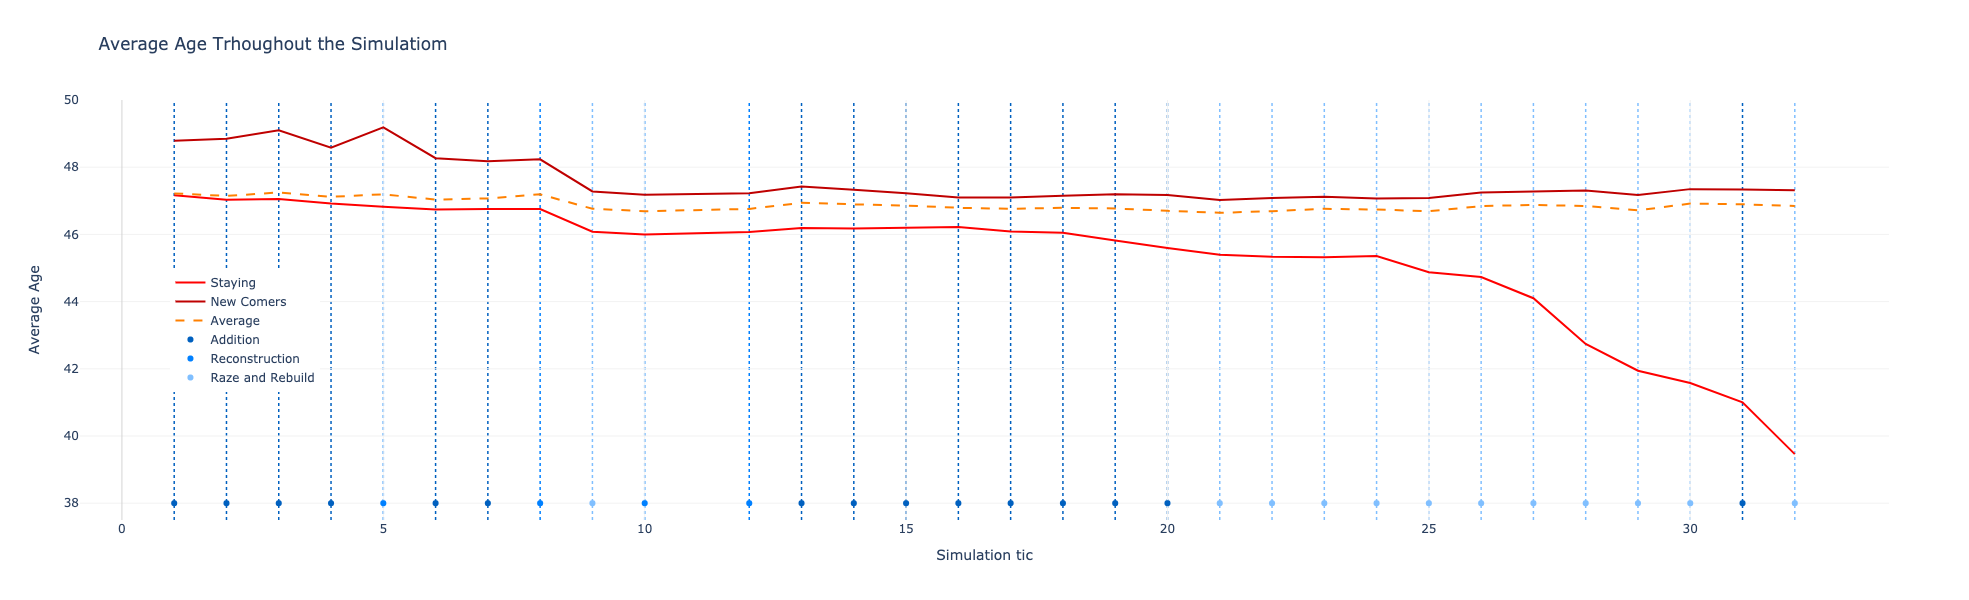

In [37]:

fig = go.Figure()
for i in range(3):
    fig.add_trace(go.Scatter(
        x=genericGraph['tic'],
        y=genericGraph[columnsList[i]],
        line=styleList[i],
        name=titlesList[i]
    ))
 

maxY=50
for xtic in aTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY, line=dict(
        color=aC, width=1.5, dash="dot"), layer="below")

for xtic in rTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY, line=dict(
        color=rC, width=1.5, dash="dot"), layer="below")

for xtic in rrTics:
    fig.add_shape(type="line", x0=xtic, y0=0, x1=xtic, y1=maxY,
                  line=dict(color=rrC, width=1.5, dash="dot"), layer="below")

    
fig.add_trace(go.Scatter(name='Addition', x=aTics, y=aYshift,
                         mode='markers', marker=dict(color=aC)))
fig.add_trace(go.Scatter(name='Reconstruction', x=rTics, y=rYshift,
                         mode='markers', marker=dict(color=rC)))
fig.add_trace(go.Scatter(name='Raze and Rebuild', x=rrTics,
                         y=rrYshift, mode='markers', marker=dict(color=rrC)))

fig.update_layout(width=widthD,height=heightD, title=title_)
fig.update_yaxes(title=y_title,range=[37.5, maxY],gridwidth=1, gridcolor=gridBG,zerolinewidth=1,zerolinecolor='lightgrey')
fig.update_xaxes(title='Simulation tic',gridwidth=1, gridcolor=gridBG,zerolinewidth=1,zerolinecolor='lightgrey')
fig.update_layout(showlegend=True,plot_bgcolor='rgba(0,0,0,0)',legend=dict(yanchor="top", y=0.6, xanchor="left", x=0.05))
fig.show()

## Rent And Go

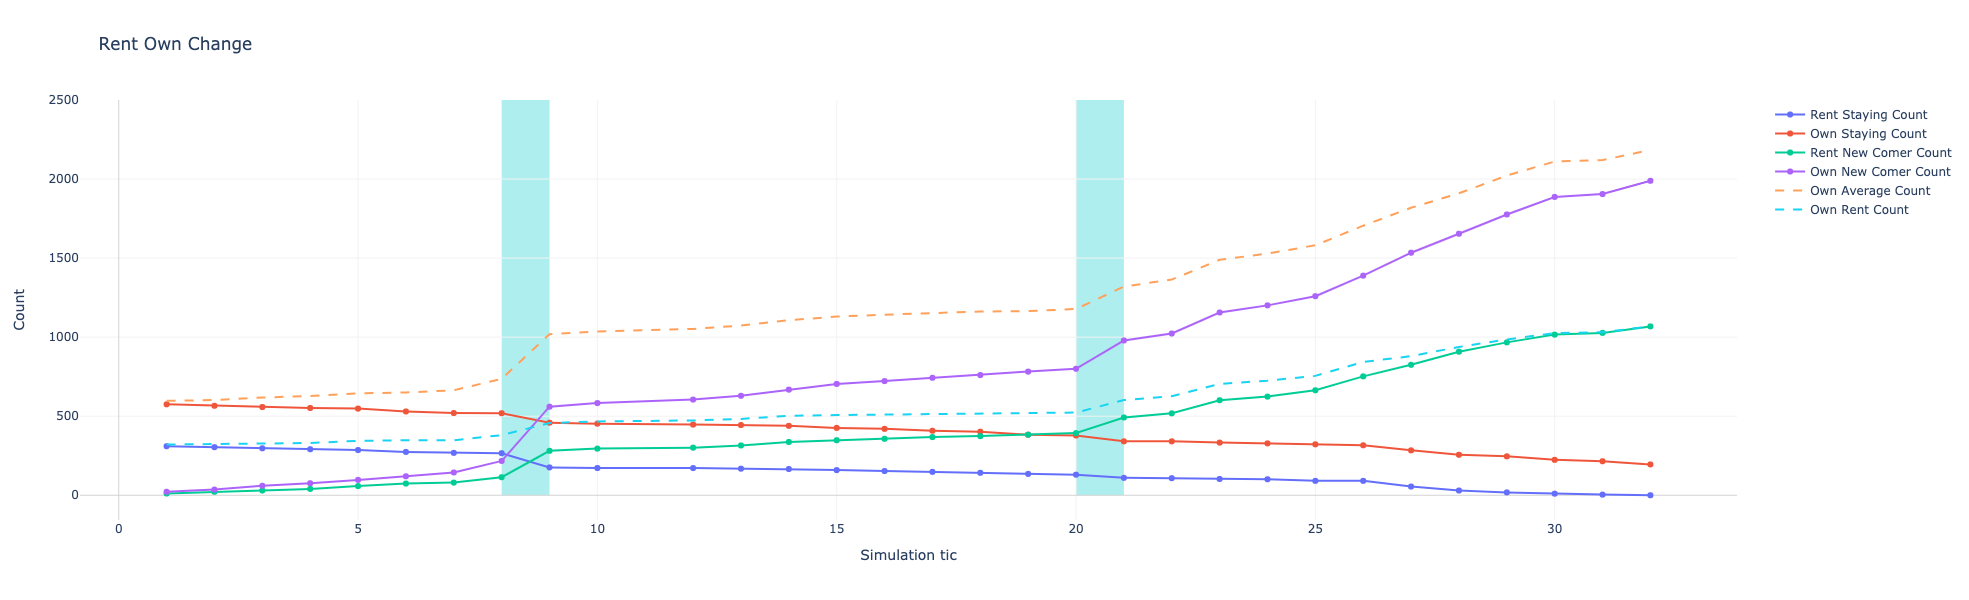

In [38]:
graph12 = res2.copy()
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=graph12['tic'],
    y=graph12['rentStayCount'],
    mode="lines+markers",
    name="Rent Staying Count"
))
fig.add_trace(go.Scatter(
    x=graph12['tic'],
    y=graph12['ownStayCount'],
    mode="lines+markers",
    name="Own Staying Count"
))
fig.add_trace(go.Scatter(
    x=graph12['tic'],
    y=graph12['rentNewCount'],
    mode="lines+markers",
    name="Rent New Comer Count"
))
fig.add_trace(go.Scatter(
    x=graph12['tic'],
    y=graph12['ownNewCount'],
    mode="lines+markers",
    name="Own New Comer Count"
))


fig.add_trace(go.Scatter(
    x=graph12['tic'],
    y=graph12['ownCount'],
    line=dict(dash='dash'),
    name="Own Average Count"
))




fig.add_trace(go.Scatter(
    x=graph12['tic'],
    y=graph12['rentCount'],
    line=dict(dash='dash'),
    name="Own Rent Count"
))





fig.add_shape(type="rect",
    x0=8, y0=0,
    x1=9, y1=2500,
    line=dict(
        color="LightSeaGreen",
        width=0,
    ),layer='below',
    fillcolor="PaleTurquoise",
)

fig.add_shape(type="rect",
    x0=20, y0=0,
    x1=21, y1=2500,
    line=dict(
        color="LightSeaGreen",
        width=0,
    ),layer='below',
    fillcolor="PaleTurquoise",visible=True
)
fig.update_layout(width=800,height=600, title='Rent Own Change')
fig.update_yaxes(title='Count',gridwidth=1, gridcolor=gridBG,zerolinewidth=1,zerolinecolor='lightgrey')
fig.update_xaxes(title='Simulation tic',gridwidth=1, gridcolor=gridBG,zerolinewidth=1,zerolinecolor='lightgrey')
fig.update_layout(showlegend=True,plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [39]:
graph12.head()

aprtmentSizeMean ProjNumber yearsInBldgMean aprtmentSizeMeanStay  \
1        75.337691   20180988        23.67756            75.089266   
2        75.616379   20100133       23.007543            75.190805   
3        75.587302   20180812       22.314286            75.660819   
4        76.027112   20181092       21.590198            75.655991   
5        76.627907   20171974       20.691608            75.944844   

  aprtmentSizeNewComer    AgeMean AgeMeanNew AgeMeanStay AgeOldStayNew  \
1                 82.0  47.220044  48.787879   47.161582         238.0   
2                 82.0  47.143319  48.844828   47.029885         237.0   
3            74.888889  47.248677       49.1   47.053801         242.0   
4            78.724138  47.117831  48.577586   46.916963         242.0   
5            80.303226  47.193124  49.187097   46.822542         250.0   

  AgeYoungStayNew AgeOldStay AgeYoungStay AgeOldNew AgeYoungNew  \
1           680.0      230.0        655.0       8.0        25.0   
2           691.0      224.0        646.0      13.0        45.0   
3           703.0      220.0        635.0      22.0        68.0   
4           717.0      214.0        629.0      28.0        88.0   
5           739.0      211.0        623.0      39.0       116.0   

  IncomeHighStay IncomeMedStay IncomeLowStay IncomeHighNew IncomeMedNew  \
1            0.0         377.0         508.0          22.0         11.0   
2            0.0         374.0         496.0          36.0         22.0   
3            0.0         365.0         490.0          36.0         54.0   
4            0.0         360.0         483.0          60.0         56.0   
5            0.0         356.0         478.0          91.0         64.0   

  IncomeLowNew IncomeHighStayNew IncomeMedStayNew IncomeLowStayNew  \
1          0.0              22.0            388.0            508.0   
2          0.0              36.0            396.0            496.0   
3          0.0              36.0            419.0            490.0   
4          0.0              60.0            416.0            483.0   
5          0.0              91.0            420.0            478.0   

  meanIncomeStay meanIncomeNewComers meanIncomeStay_N_new rentCount ownCount  \
1    7626.976271         20161.14673          8077.551026     321.0    597.0   
2    7622.918391         20302.00363          8415.361218     326.0    602.0   
3    7587.665497        18955.571345          8670.323197     327.0    618.0   
4    7576.147094         19680.70735          9040.306624     331.0    628.0   
5    7557.907674        19907.799151          9493.431616     344.0    645.0   

  rentStayCount rentNewCount ownStayCount ownNewCount TotalAgentsCount  \
1         310.0         11.0        575.0        22.0            918.0   
2         304.0         22.0        566.0        36.0            928.0   
3         297.0         30.0        558.0        60.0            945.0   
4         291.0         40.0        552.0        76.0            959.0   
5         286.0         58.0        548.0        97.0            989.0   

  prjectType tic   stay new comers CostForStaying rentPrice  leave  \
1          1   1  885.0       33.0     248.878715       0.0   12.0   
2          1   2  870.0       58.0      427.65347       0.0   27.0   
3          1   3  855.0       90.0     597.379746       0.0   42.0   
4          1   4  843.0      116.0     795.139374       0.0   54.0   
5          2   5  834.0      155.0    1050.745511       0.0   63.0   

    Project Type   y_shift  
1        Addition      -20  
2        Addition      -20  
3        Addition      -20  
4        Addition      -20  
5  Reconstruction      -20

In [40]:
graph12 = graph12[['tic','rentStayCount','ownStayCount','rentNewCount','ownNewCount','ownCount','rentCount','TotalAgentsCount']].copy()

In [41]:
graph12.head()

tic rentStayCount ownStayCount rentNewCount ownNewCount ownCount rentCount  \
1   1         310.0        575.0         11.0        22.0    597.0     321.0   
2   2         304.0        566.0         22.0        36.0    602.0     326.0   
3   3         297.0        558.0         30.0        60.0    618.0     327.0   
4   4         291.0        552.0         40.0        76.0    628.0     331.0   
5   5         286.0        548.0         58.0        97.0    645.0     344.0   

  TotalAgentsCount  
1            918.0  
2            928.0  
3            945.0  
4            959.0  
5            989.0

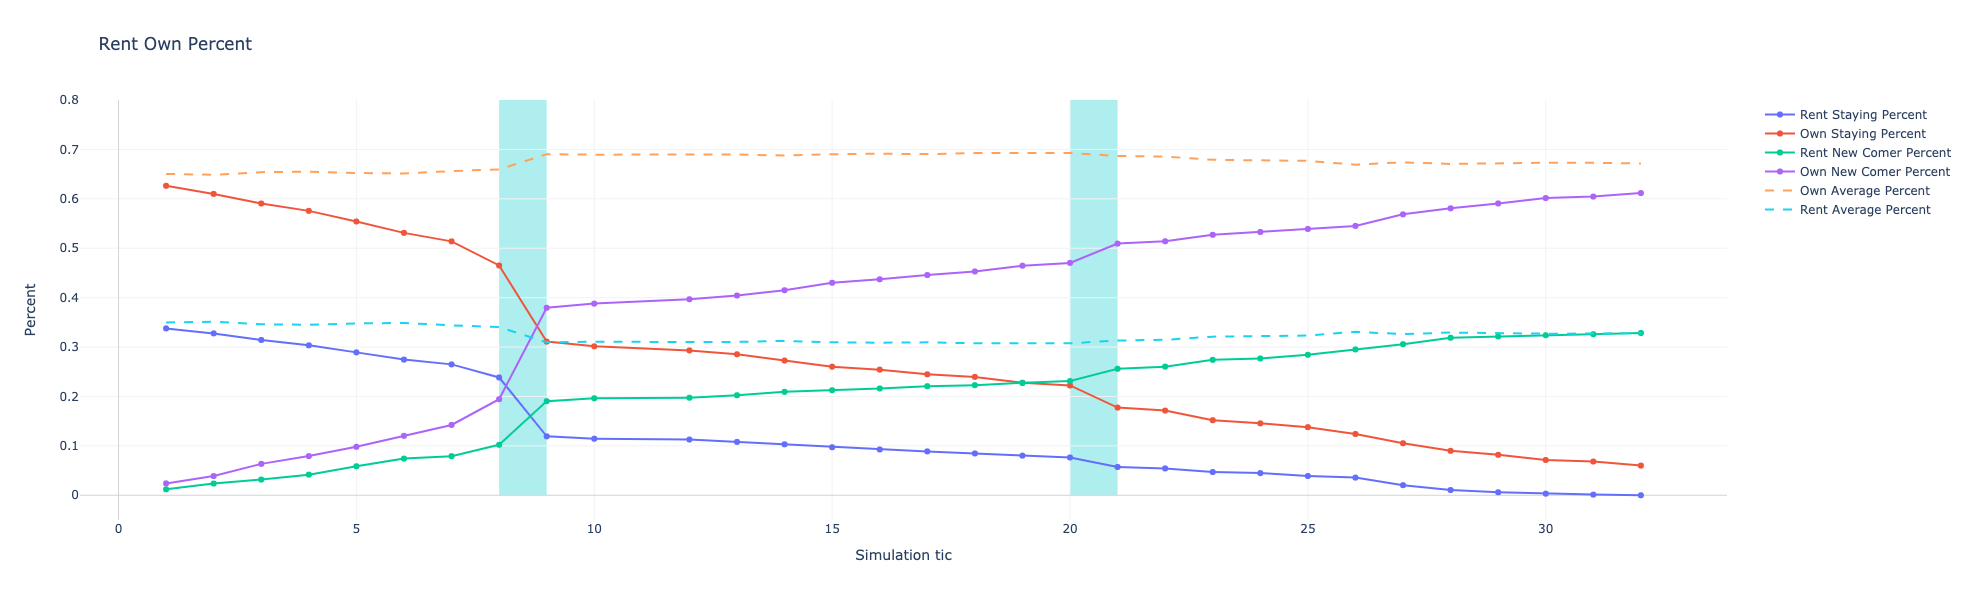

In [42]:
graph12['rentStayPercent'] = graph12['rentStayCount']/graph12['TotalAgentsCount']
graph12['ownStayPercent'] = graph12['ownStayCount']/graph12['TotalAgentsCount']
graph12['rentNewPercent'] = graph12['rentNewCount']/graph12['TotalAgentsCount']
graph12['ownNewPercent'] = graph12['ownNewCount']/graph12['TotalAgentsCount']
graph12['ownPercent'] = graph12['ownCount']/graph12['TotalAgentsCount']
graph12['rentPercent'] = graph12['rentCount']/graph12['TotalAgentsCount']
#graph12[''rentStayCount','ownStayCount','rentNewCount','ownNewCount','ownCount','rentCount','TotalAgentsCount'']
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=graph12['tic'],
    y=graph12['rentStayPercent'],
    mode="lines+markers",
    name="Rent Staying Percent"
))
fig.add_trace(go.Scatter(
    x=graph12['tic'],
    y=graph12['ownStayPercent'],
    mode="lines+markers",
    name="Own Staying Percent"
))
fig.add_trace(go.Scatter(
    x=graph12['tic'],
    y=graph12['rentNewPercent'],
    mode="lines+markers",
    name="Rent New Comer Percent"
))
fig.add_trace(go.Scatter(
    x=graph12['tic'],
    y=graph12['ownNewPercent'],
    mode="lines+markers",
    name="Own New Comer Percent"
))


fig.add_trace(go.Scatter(
    x=graph12['tic'],
    y=graph12['ownPercent'],
    line=dict(dash='dash'),
    name="Own Average Percent"
))




fig.add_trace(go.Scatter(
    x=graph12['tic'],
    y=graph12['rentPercent'],
    line=dict(dash='dash'),
    name="Rent Average Percent"
))



fig.add_shape(type="rect",
    x0=8, y0=0,
    x1=9, y1=0.8,
    line=dict(
        color="LightSeaGreen",
        width=0,
    ),layer='below',
    fillcolor="PaleTurquoise",
)

fig.add_shape(type="rect",
    x0=20, y0=0,
    x1=21, y1=0.8,
    line=dict(
        color="LightSeaGreen",
        width=0,
    ),layer='below',
    fillcolor="PaleTurquoise",visible=True
)
fig.update_layout(width=1000,height=600, title='Rent Own Percent')
fig.update_yaxes(title='Percent',gridwidth=1, gridcolor=gridBG,zerolinewidth=1,zerolinecolor='lightgrey')
fig.update_xaxes(title='Simulation tic',gridwidth=1, gridcolor=gridBG,zerolinewidth=1,zerolinecolor='lightgrey')
fig.update_layout(showlegend=True,plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [49]:
subset_before_after = res_df.copy()
subset_before_after = subset_before_after[subset_before_after['status']!='leave']

In [50]:
subset_before_after['simulationState'] =subset_before_after['tic'].apply(lambda x: 'Before Renewal' if x==0 else 'After Renewal')

In [51]:
subset_before_after['simulationState'].value_counts()

After Renewal     3252
Before Renewal     897
Name: simulationState, dtype: int64

In [52]:
subset_before_after.head(1)

Unnamed: 0 bldCode  doorIndex bldCodeDoorIndex ProjNumber  aprtmentSize  \
0           0  210_19          1         210_19_1   20180988            70   

   yearsInBldg  age  lowDiscount  highDiscount  noDiscount  income  rent  own  \
0           32   19            0             1           0  5145.0     0    1   

                                agentID  prjectType  tic status  Floors  \
0  2a6d0426-9b6a-11eb-ab03-acde48001122           0    0   stay     0.0   

   MainCost  cityTax  CostForStaying  ratioCostForStaying reason_leave  \
0       0.0      0.0             0.0                  0.0            0   

   mortgage  rentPrice  stay  leave  New Comers  Under 65  Above 65  \
0         0        0.0     1      0           0         1         0   

   Low Income  Medium Income  High Income simulationState  
0           1              0            0  Before Renewal

In [53]:
CostForStaying = subset_before_after[subset_before_after['simulationState']=='After Renewal'][['stay','New Comers','rent','own','CostForStaying']]

In [54]:
CostForStaying.head(1)

stay  New Comers  rent  own  CostForStaying
899     1           0     0    1          765.26

In [55]:
CostForStayingStay =CostForStaying.query('stay==1')['CostForStaying']
CostForStayingNew = CostForStaying.query('`New Comers`==1')['CostForStaying']
CostForStayingRent = CostForStaying.query('rent==1')['CostForStaying']
CostForStayingOwn = CostForStaying.query('own==1')['CostForStaying']

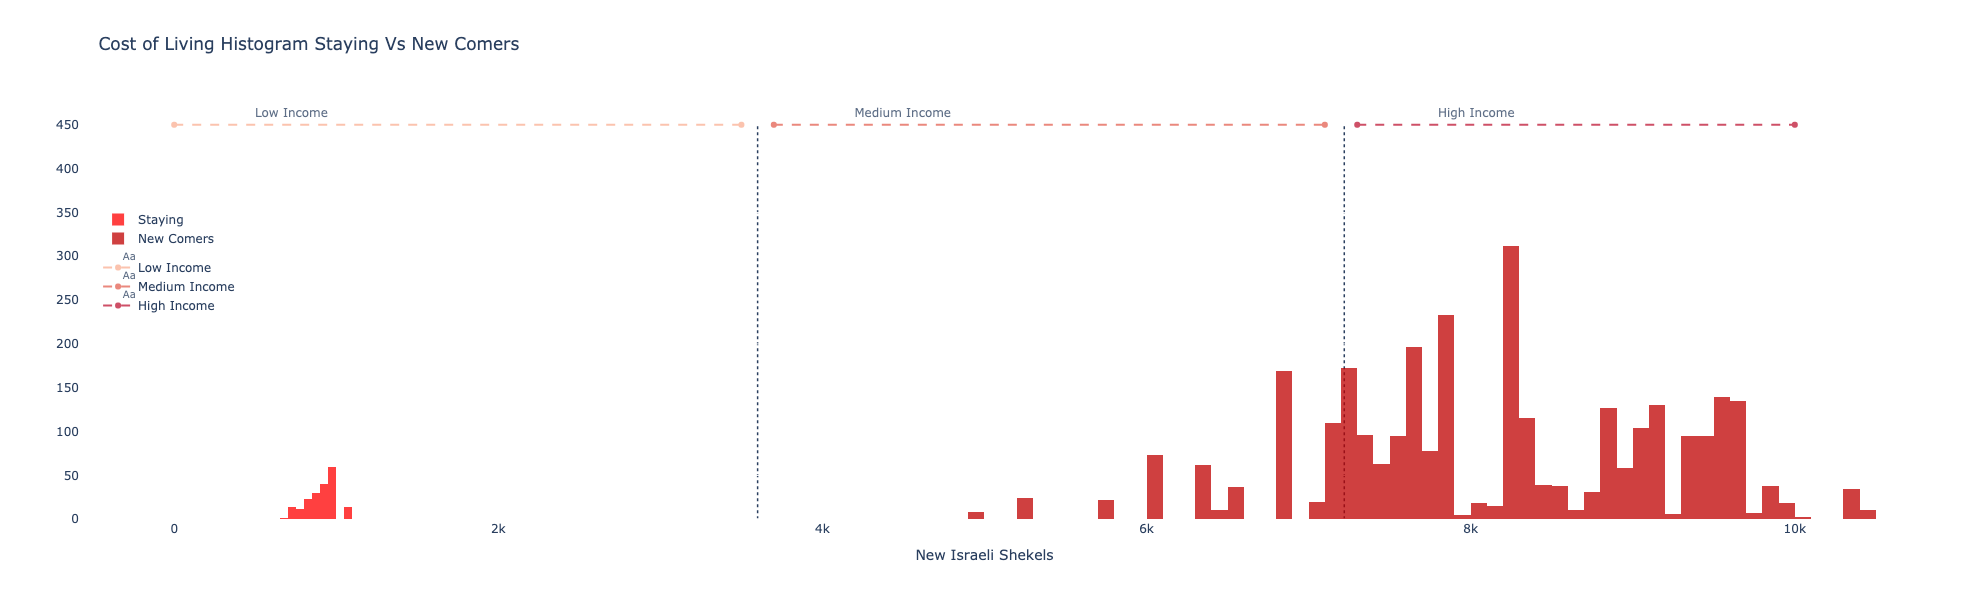

In [56]:

fig = go.Figure()
fig.add_trace(go.Histogram(x=CostForStayingStay,name='Staying',marker_color = stayingC,legendgroup="newstay"))
fig.add_trace(go.Histogram(x=CostForStayingNew,name='New Comers',marker_color = newComerC,legendgroup="newstay"))
fig.add_shape(type="line", x0=3600, y0=0, x1=3600, y1=450,
                  line=dict(width=1.5, dash="dot"), layer="below")
fig.add_shape(type="line", x0=7220, y0=0, x1=7220, y1=450,
                  line=dict(width=1.5, dash="dot"), layer="below")

fig.add_trace(go.Scatter(
    x=[0, 3500],
    y=[450, 450],
    mode="lines+markers+text",
    name="Low Income",
    line=dict(color=lowIncomeC,dash='dash'),
    text=["                  Low Income"],
    textposition="top right",
    legendgroup="annotation"
))
fig.add_trace(go.Scatter(
    x=[3700, 7100],
    y=[450, 450],
    mode="lines+markers+text",
    name="Medium Income",
    line=dict(color=medIncomeC,dash='dash'),
    text=["                  Medium Income"],
    textposition="top right",
    legendgroup="annotation"
))

fig.add_trace(go.Scatter(
    x=[7300, 10000],
    y=[450, 450],
    mode="lines+markers+text",
    name="High Income",
    line=dict(color=upIncomeC,dash='dash'),
    text=["                  High Income"],
    textposition="top right",
    legendgroup="annotation"
))
# Overlay both histograms
fig.update_layout(barmode='overlay',title='Cost of Living Histogram Staying Vs New Comers',
                 legend=dict(yanchor="top", y=0.75, xanchor="left", x=0.01),
                 plot_bgcolor='rgba(0,0,0,0)', xaxis_title_text='New Israeli Shekels',
                  width=widthD,height=heightD)

# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

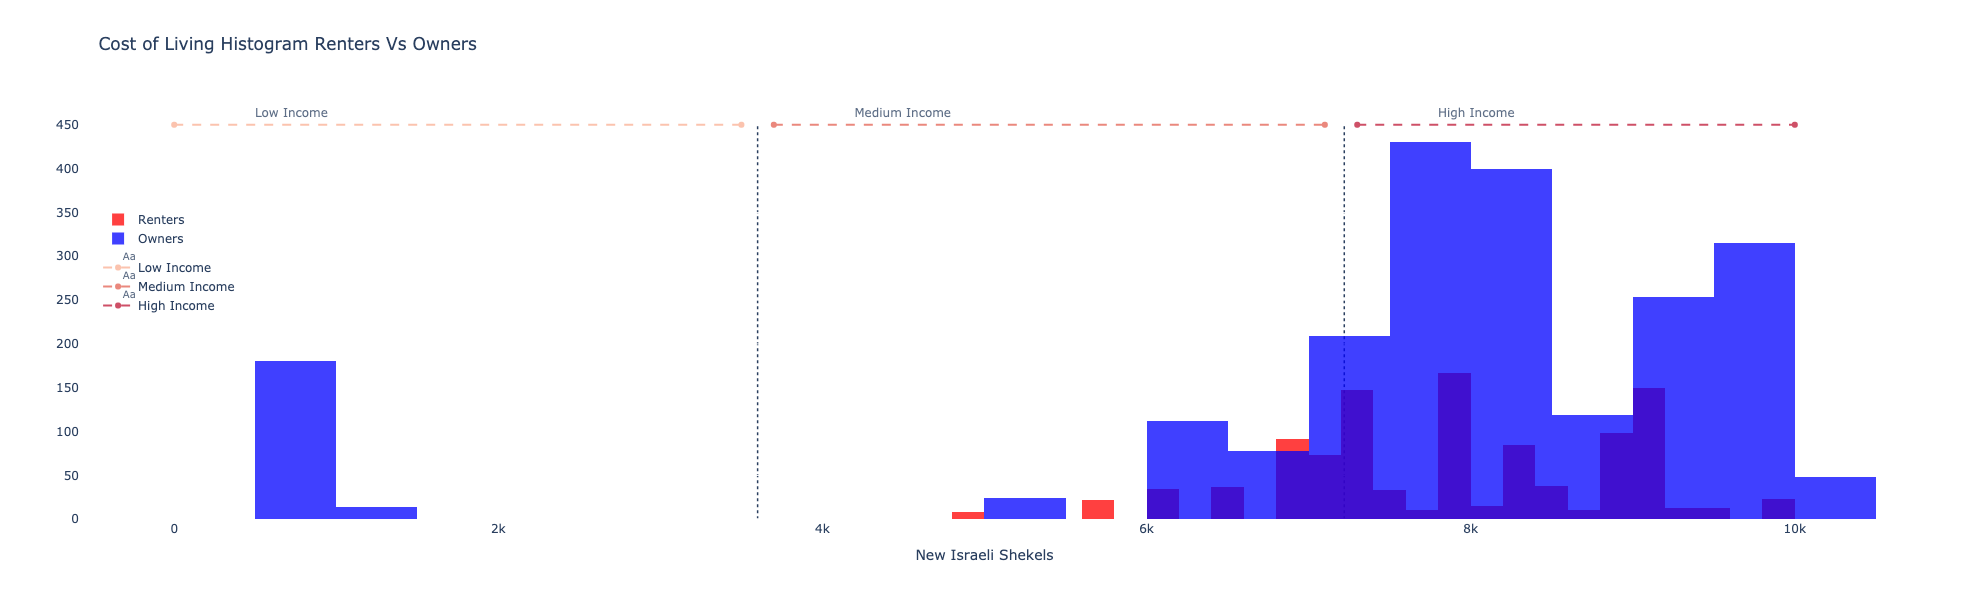

In [57]:

fig = go.Figure()
fig.add_trace(go.Histogram(x=CostForStayingRent,name='Renters',marker_color = 'red',legendgroup="ownership"))
fig.add_trace(go.Histogram(x=CostForStayingOwn,name='Owners',marker_color = 'blue',legendgroup="ownership"))
fig.add_shape(type="line", x0=3600, y0=0, x1=3600, y1=450,
                  line=dict(width=1.5, dash="dot"), layer="below")
fig.add_shape(type="line", x0=7220, y0=0, x1=7220, y1=450,
                  line=dict(width=1.5, dash="dot"), layer="below")

fig.add_trace(go.Scatter(
    x=[0, 3500],
    y=[450, 450],
    mode="lines+markers+text",
    name="Low Income",
    line=dict(color=lowIncomeC,dash='dash'),
    text=["                  Low Income"],
    textposition="top right",
    legendgroup="annotation"
))
fig.add_trace(go.Scatter(
    x=[3700, 7100],
    y=[450, 450],
    mode="lines+markers+text",
    name="Medium Income",
    line=dict(color=medIncomeC,dash='dash'),
    text=["                  Medium Income"],
    textposition="top right",
    legendgroup="annotation"
))

fig.add_trace(go.Scatter(
    x=[7300, 10000],
    y=[450, 450],
    mode="lines+markers+text",
    name="High Income",
    line=dict(color=upIncomeC,dash='dash'),
    text=["                  High Income"],
    textposition="top right",
    legendgroup="annotation"
))
# Overlay both histograms
fig.update_layout(barmode='overlay',title='Cost of Living Histogram Renters Vs Owners',
                 legend=dict(yanchor="top", y=0.75, xanchor="left", x=0.01),
                 plot_bgcolor='rgba(0,0,0,0)', xaxis_title_text='New Israeli Shekels',
                  width=widthD,height=heightD)

# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

In [59]:
sub_1_32 = subset_before_after[['simulationState','income','age','agentID']].copy()

In [60]:
sub_1_32['ageGroup'] = sub_1_32['age'].apply(lambda x: 'Under 65' if x<65 else 'Above 65')
sub_1_32['incomeGroup'] = sub_1_32['income'].apply(lambda x: 'High Income' if x>=19500  
                                                   else  ('Medium Income' if ((x>=9000)&(x<19500)) else 'Low Income'))

In [61]:
sub_1_32['incomeGroup'].value_counts()

High Income      2809
Medium Income     748
Low Income        592
Name: incomeGroup, dtype: int64

In [93]:
sub_1_32 = sub_1_32[['simulationState','ageGroup','incomeGroup','agentID']].copy()

In [94]:
ageIncome1_32 = sub_1_32.groupby(['simulationState','ageGroup','incomeGroup']).agg({'agentID':'count'}).reset_index()

In [95]:
ageIncome1_32

simulationState  ageGroup    incomeGroup  agentID
0   After Renewal  Above 65    High Income      566
1   After Renewal  Above 65     Low Income        5
2   After Renewal  Above 65  Medium Income       63
3   After Renewal  Under 65    High Income     2243
4   After Renewal  Under 65     Low Income       74
5   After Renewal  Under 65  Medium Income      301
6  Before Renewal  Above 65     Low Income      126
7  Before Renewal  Above 65  Medium Income      106
8  Before Renewal  Under 65     Low Income      387
9  Before Renewal  Under 65  Medium Income      278

In [96]:
age_income_color = ageIncome1_32[['Age Group','Income Group']].drop_duplicates()

KeyError: "None of [Index(['Age Group', 'Income Group'], dtype='object')] are in the [columns]"

In [88]:
age_income_color['Age_income'] = age_income_color['Age Group'] + " "+ age_income_color['Income Group']

In [97]:
age_income_color

Age_income               color
0    Above 65 High Income  HSV(280, 28%, 58%)
1     Above 65 Low Income   HSV(83, 13%, 72%)
2  Above 65 Medium Income  HSV(312, 34%, 65%)
3    Under 65 High Income    HSV(323,57%,39%)
4     Under 65 Low Income    HSV(44,37%, 55%)
5  Under 65 Medium Income  HSV(333, 65%, 51%)

In [76]:
#age_income_color['color'] = ['HSV(280, 28%, 58%)','HSV(83, 13%, 72%)','HSV(312, 34%, 65%)','HSV(323,57%,39%)','HSV(44,37%, 55%)','HSV(333, 65%, 51%)']

In [78]:
#age_income_color.to_excel('age_income_by_color_april_14.xlsx')

In [98]:
age_income_color

Age_income               color
0    Above 65 High Income  HSV(280, 28%, 58%)
1     Above 65 Low Income   HSV(83, 13%, 72%)
2  Above 65 Medium Income  HSV(312, 34%, 65%)
3    Under 65 High Income    HSV(323,57%,39%)
4     Under 65 Low Income    HSV(44,37%, 55%)
5  Under 65 Medium Income  HSV(333, 65%, 51%)

In [99]:
ageIncome1_32

simulationState  ageGroup    incomeGroup  agentID
0   After Renewal  Above 65    High Income      566
1   After Renewal  Above 65     Low Income        5
2   After Renewal  Above 65  Medium Income       63
3   After Renewal  Under 65    High Income     2243
4   After Renewal  Under 65     Low Income       74
5   After Renewal  Under 65  Medium Income      301
6  Before Renewal  Above 65     Low Income      126
7  Before Renewal  Above 65  Medium Income      106
8  Before Renewal  Under 65     Low Income      387
9  Before Renewal  Under 65  Medium Income      278

In [91]:
age_income_color = age_income_color[['Age_income','color']]

In [104]:
ageIncome1_32['Age_Income'] = ageIncome1_32['ageGroup'] + " "+ ageIncome1_32['incomeGroup']

In [106]:
ageIncome1_32 = pd.merge(ageIncome1_32,age_income_color,left_on='Age_Income',right_on='Age_income',how='left')

In [108]:
ageIncome1_32.drop(columns='Age_income',inplace=True)

In [109]:
ageIncome1_32.rename(columns={'ageGroup':'Age Group','incomeGroup':'Income Group','agentID':'Count'},inplace=True)

In [113]:
ageIncome1_32

simulationState Age Group   Income Group  Count              Age_Income  \
0   After Renewal  Above 65    High Income    566    Above 65 High Income   
1   After Renewal  Above 65     Low Income      5     Above 65 Low Income   
2   After Renewal  Above 65  Medium Income     63  Above 65 Medium Income   
3   After Renewal  Under 65    High Income   2243    Under 65 High Income   
4   After Renewal  Under 65     Low Income     74     Under 65 Low Income   
5   After Renewal  Under 65  Medium Income    301  Under 65 Medium Income   
6  Before Renewal  Above 65     Low Income    126     Above 65 Low Income   
7  Before Renewal  Above 65  Medium Income    106  Above 65 Medium Income   
8  Before Renewal  Under 65     Low Income    387     Under 65 Low Income   
9  Before Renewal  Under 65  Medium Income    278  Under 65 Medium Income   

                color  
0  HSV(280, 28%, 58%)  
1   HSV(83, 13%, 72%)  
2  HSV(312, 34%, 65%)  
3    HSV(323,57%,39%)  
4    HSV(44,37%, 55%)  
5  HSV(333, 65%, 51%)  
6   HSV(83, 13%, 72%)  
7  HSV(312, 34%, 65%)  
8    HSV(44,37%, 55%)  
9  HSV(333, 65%, 51%)

In [115]:
ageIncomeColorDict = dict(zip(ageIncome1_32['Age_Income'],ageIncome1_32['color']))

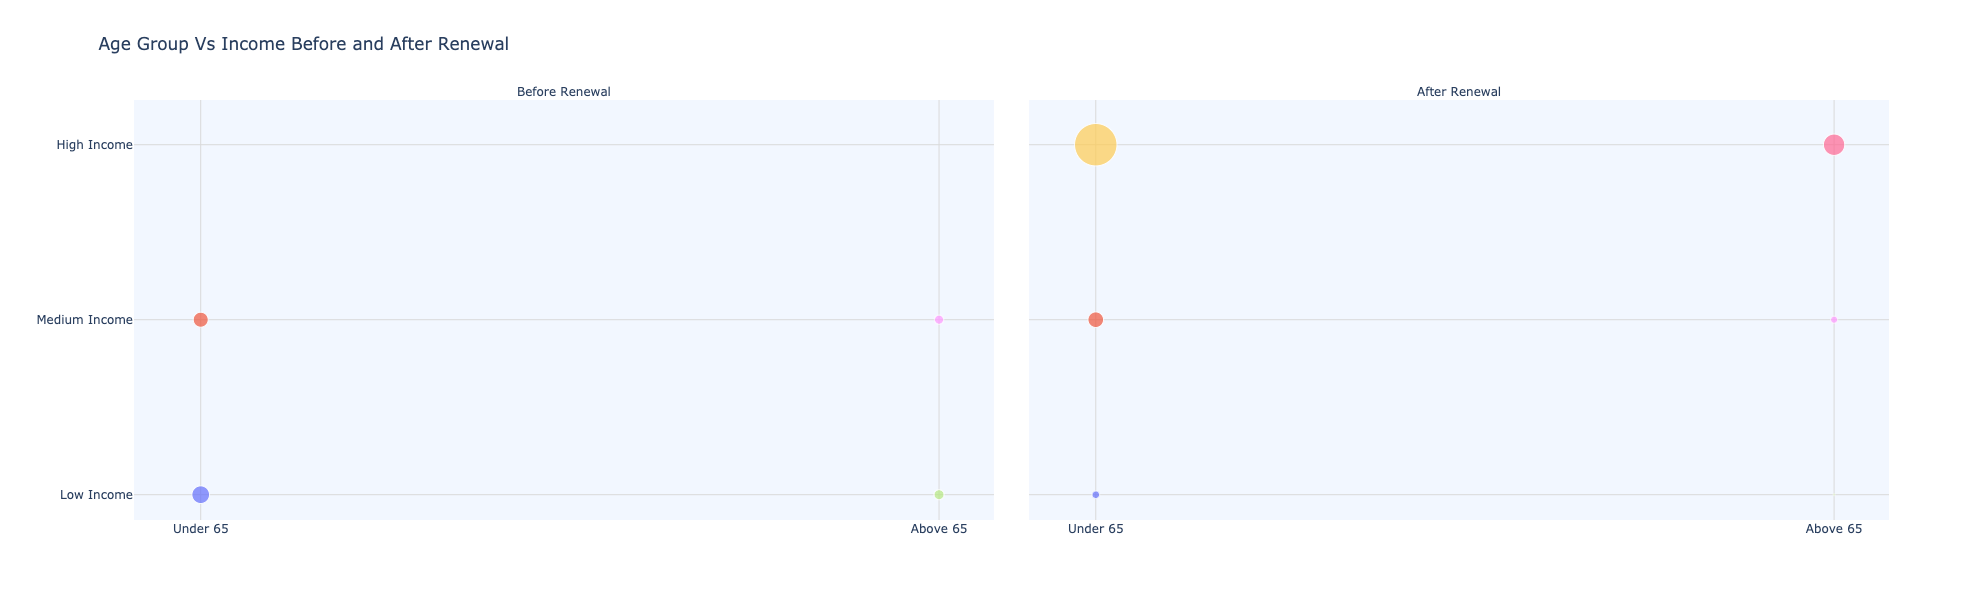

In [124]:
import plotly.express as px
title_ = 'Age Group Vs Income Before and After Renewal'

fig = px.scatter(ageIncome1_32, x="Age Group", y="Income Group",
            size="Count",facet_col='simulationState', title=title_,size_max=30,
            category_orders={"Age Group": ["Under 65","Above 65"],
                            "Income Group": ['High Income', 'Medium Income', 'Low Income'],
                            "simulationState":['Before Renewal','After Renewal']},color='color',color_discrete_map=ageIncomeColorDict,width=900,height=600)
fig.update_yaxes(gridwidth=1, gridcolor='#d9d9d9',zerolinewidth=1,zerolinecolor='lightgrey',title='')
fig.update_xaxes(gridwidth=1, gridcolor='#d9d9d9',zerolinewidth=1,zerolinecolor='lightgrey',title='')
fig.update_layout(plot_bgcolor='#f2f7ff')
fig.layout['annotations'][0]['text'] = 'Before Renewal'
fig.layout['annotations'][1]['text'] = 'After Renewal'
fig.update_traces(showlegend=False)

In [67]:
res2.head()

aprtmentSizeMean ProjNumber yearsInBldgMean aprtmentSizeMeanStay  \
1        75.337691   20180988        23.67756            75.089266   
2        75.616379   20100133       23.007543            75.190805   
3        75.587302   20180812       22.314286            75.660819   
4        76.027112   20181092       21.590198            75.655991   
5        76.627907   20171974       20.691608            75.944844   

  aprtmentSizeNewComer    AgeMean AgeMeanNew AgeMeanStay AgeOldStayNew  \
1                 82.0  47.220044  48.787879   47.161582         238.0   
2                 82.0  47.143319  48.844828   47.029885         237.0   
3            74.888889  47.248677       49.1   47.053801         242.0   
4            78.724138  47.117831  48.577586   46.916963         242.0   
5            80.303226  47.193124  49.187097   46.822542         250.0   

  AgeYoungStayNew AgeOldStay AgeYoungStay AgeOldNew AgeYoungNew  \
1           680.0      230.0        655.0       8.0        25.0   
2           691.0      224.0        646.0      13.0        45.0   
3           703.0      220.0        635.0      22.0        68.0   
4           717.0      214.0        629.0      28.0        88.0   
5           739.0      211.0        623.0      39.0       116.0   

  IncomeHighStay IncomeMedStay IncomeLowStay IncomeHighNew IncomeMedNew  \
1            0.0         377.0         508.0          22.0         11.0   
2            0.0         374.0         496.0          36.0         22.0   
3            0.0         365.0         490.0          36.0         54.0   
4            0.0         360.0         483.0          60.0         56.0   
5            0.0         356.0         478.0          91.0         64.0   

  IncomeLowNew IncomeHighStayNew IncomeMedStayNew IncomeLowStayNew  \
1          0.0              22.0            388.0            508.0   
2          0.0              36.0            396.0            496.0   
3          0.0              36.0            419.0            490.0   
4          0.0              60.0            416.0            483.0   
5          0.0              91.0            420.0            478.0   

  meanIncomeStay meanIncomeNewComers meanIncomeStay_N_new rentCount ownCount  \
1    7626.976271         20161.14673          8077.551026     321.0    597.0   
2    7622.918391         20302.00363          8415.361218     326.0    602.0   
3    7587.665497        18955.571345          8670.323197     327.0    618.0   
4    7576.147094         19680.70735          9040.306624     331.0    628.0   
5    7557.907674        19907.799151          9493.431616     344.0    645.0   

  rentStayCount rentNewCount ownStayCount ownNewCount TotalAgentsCount  \
1         310.0         11.0        575.0        22.0            918.0   
2         304.0         22.0        566.0        36.0            928.0   
3         297.0         30.0        558.0        60.0            945.0   
4         291.0         40.0        552.0        76.0            959.0   
5         286.0         58.0        548.0        97.0            989.0   

  prjectType tic   stay new comers CostForStaying rentPrice  leave  \
1          1   1  885.0       33.0     248.878715       0.0   12.0   
2          1   2  870.0       58.0      427.65347       0.0   27.0   
3          1   3  855.0       90.0     597.379746       0.0   42.0   
4          1   4  843.0      116.0     795.139374       0.0   54.0   
5          2   5  834.0      155.0    1050.745511       0.0   63.0   

    Project Type   y_shift  
1        Addition      -20  
2        Addition      -20  
3        Addition      -20  
4        Addition      -20  
5  Reconstruction      -20

In [364]:
Addition = res2[['tic','stay','leave','new comers','TotalAgentsCount','prjectType']].copy()

In [365]:
Addition['Stay Addition'] = Addition['stay'].sort_values(ascending=True).diff().values[::-1]

In [366]:
Addition.loc[32,'Stay Addition'] = 0

In [367]:
Addition['leaveAddition'] = Addition['leave'].diff()

In [368]:
Addition.loc[1,'leaveAddition']=12

In [369]:
Addition['new comers Addition'] = Addition['new comers'].diff()

In [370]:
Addition.loc[1,'new comers Addition']=33

In [371]:
Addition = Addition[['tic','Stay Addition','leaveAddition','new comers Addition','prjectType']].copy()

In [372]:
Addition = Addition.rename(columns={'tic':'Tic','Stay Addition':'Staying','leaveAddition':'Leaving','new comers Addition':'New Comers','prjectType':'Project Type'})

In [373]:
Addition.head()

Tic Staying  Leaving New Comers Project Type
1   1    15.0     12.0         33            1
2   2    15.0     15.0       25.0            1
3   3    12.0     15.0       32.0            1
4   4     9.0     12.0       26.0            1
5   5    30.0      9.0       39.0            2

In [374]:
Addition['Project Type 2'] = Addition['Project Type']
Addition.loc[Addition['Project Type 2']==1,'Project Type'] = 'Addition'
Addition.loc[Addition['Project Type 2']==2,'Project Type'] = 'Reconstruction'
Addition.loc[Addition['Project Type 2']==3,'Project Type'] = 'Raze and Rebuild'

In [375]:
Addition['y_shift'] = -10

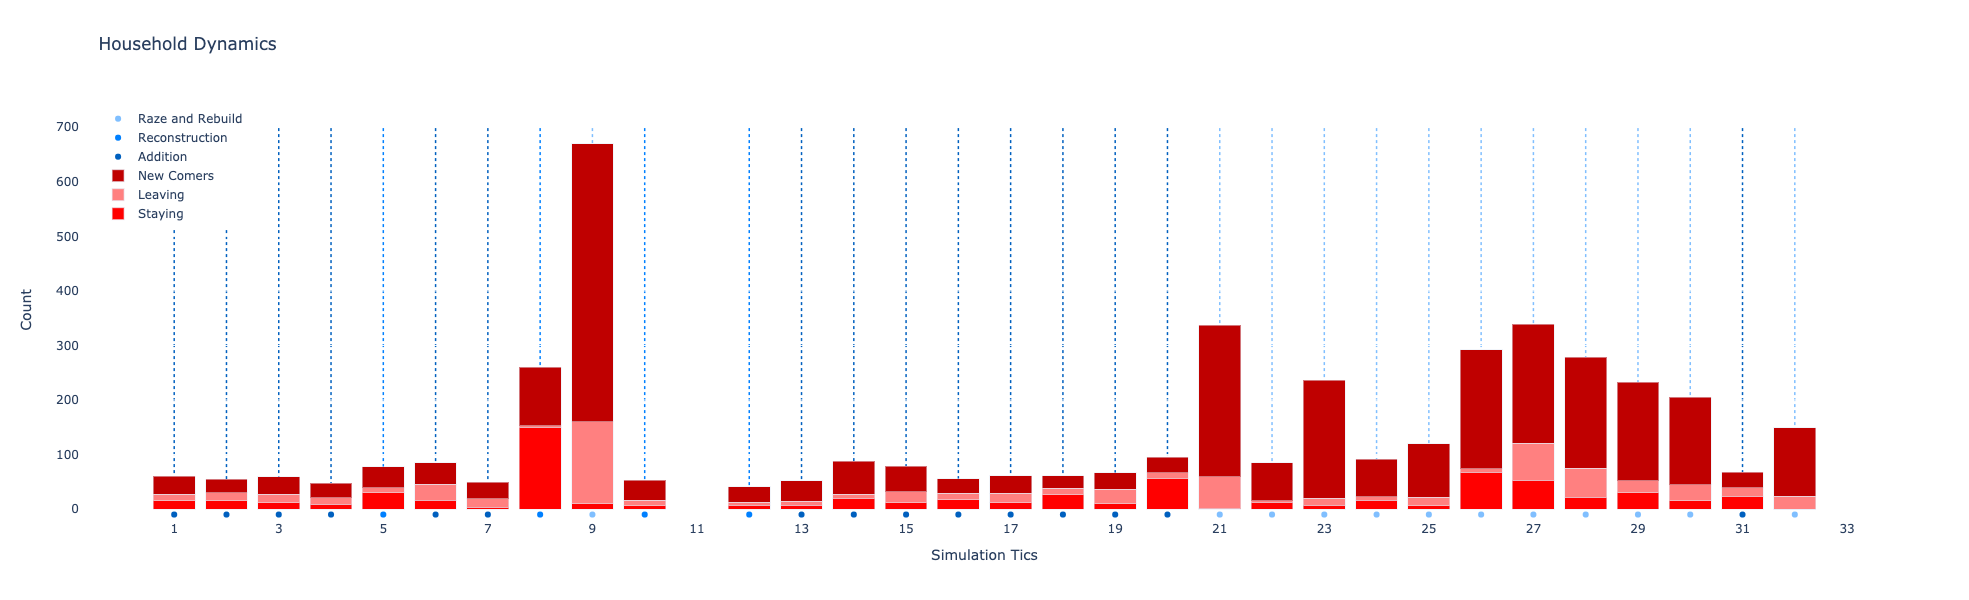

In [376]:
#fig = px.bar(Addition, x="Tic", y=["Staying", "Leaving", "New Comers"], title="Household Dynamics")


fig = go.Figure(data=[go.Bar(name='Staying', x=Addition['Tic'], y=Addition['Staying'],marker=dict(color=stayingC)),
                      go.Bar(name='Leaving', x=Addition['Tic'], y=Addition['Leaving'],marker=dict(color=leavingC)),
                      go.Bar(name='New Comers', x=Addition['Tic'], y=Addition['New Comers'],marker=dict(color=newComerC))
                     ])
# Change the bar mode
aTics = Addition.loc[Addition['Project Type 2']==1,'Tic']
aYshift = Addition.loc[Addition['Project Type 2']==1,'y_shift']

rTics = Addition.loc[Addition['Project Type 2']==2,'Tic']
rYshift = Addition.loc[Addition['Project Type 2']==2,'y_shift']

rrTics = Addition.loc[Addition['Project Type 2']==3,'Tic']
rrYshift = Addition.loc[Addition['Project Type 2']==3,'y_shift']

for xtic in aTics:
    fig.add_shape(type="line",x0=xtic, y0=0, x1=xtic, y1=700,line=dict(color=aC,width=1.5,dash="dot"),layer="below")

for xtic in rTics:
    fig.add_shape(type="line",x0=xtic, y0=0, x1=xtic, y1=700,line=dict(color=rC,width=1.5,dash="dot"),layer="below")

for xtic in rrTics:
    fig.add_shape(type="line",x0=xtic, y0=0, x1=xtic, y1=700,line=dict(color=rrC,width=1.5,dash="dot"),layer="below")
     

fig.add_trace(go.Scatter(name='Addition',x=aTics, y=aYshift,mode='markers', marker=dict(color=aC)))
fig.add_trace(go.Scatter(name='Reconstruction',x=rTics, y=rYshift ,mode='markers', marker=dict(color=rC)))
fig.add_trace(go.Scatter(name='Raze and Rebuild',x=rrTics, y=rrYshift ,mode='markers', marker=dict(color=rrC)))

fig.update_layout(title_text='Household Dynamics', barmode='stack',width=900,height=600,plot_bgcolor='rgba(0,0,0,0)',
                  legend=dict(yanchor="top",y=0.99,xanchor="left",x=0.01),
                  xaxis = dict(tick0 = 1,dtick = 2))

fig.update_yaxes(range=[-20,750 ],title='Count')
fig.update_xaxes(title='Simulation Tics')
fig.show()

In [94]:
Addition

Tic Staying  Leaving New Comers      Project Type    Project Type 2  \
1    1    15.0     12.0         33          Addition          Addition   
2    2    15.0     15.0       25.0          Addition          Addition   
3    3    12.0     15.0       32.0          Addition          Addition   
4    4     9.0     12.0       26.0          Addition          Addition   
5    5    30.0      9.0       39.0    Reconstruction    Reconstruction   
6    6    16.0     30.0       39.0          Addition          Addition   
7    7     3.0     16.0       30.0          Addition          Addition   
8    8   150.0      3.0      107.0    Reconstruction    Reconstruction   
9    9    10.0    150.0      510.0  Raze and Rebuild  Raze and Rebuild   
10  10     6.0     10.0       37.0    Reconstruction    Reconstruction   
12  12     7.0      6.0       28.0    Reconstruction    Reconstruction   
13  13     7.0      7.0       38.0          Addition          Addition   
14  14    20.0      7.0       61.0          Addition          Addition   
15  15    12.0     20.0       47.0          Addition          Addition   
16  16    17.0     12.0       27.0          Addition          Addition   
17  17    12.0     17.0       32.0          Addition          Addition   
18  18    26.0     12.0       23.0          Addition          Addition   
19  19    10.0     26.0       31.0          Addition          Addition   
20  20    57.0     10.0       28.0          Addition          Addition   
21  21     2.0     57.0      278.0  Raze and Rebuild  Raze and Rebuild   
22  22    13.0      2.0       70.0  Raze and Rebuild  Raze and Rebuild   
23  23     7.0     13.0      216.0  Raze and Rebuild  Raze and Rebuild   
24  24    16.0      7.0       68.0  Raze and Rebuild  Raze and Rebuild   
25  25     6.0     16.0       98.0  Raze and Rebuild  Raze and Rebuild   
26  26    68.0      6.0      218.0  Raze and Rebuild  Raze and Rebuild   
27  27    53.0     68.0      218.0  Raze and Rebuild  Raze and Rebuild   
28  28    22.0     53.0      203.0  Raze and Rebuild  Raze and Rebuild   
29  29    30.0     22.0      181.0  Raze and Rebuild  Raze and Rebuild   
30  30    15.0     30.0      160.0  Raze and Rebuild  Raze and Rebuild   
31  31    24.0     15.0       29.0          Addition          Addition   
32  32       0     24.0      125.0  Raze and Rebuild  Raze and Rebuild   

    y_shift  
1       -10  
2       -10  
3       -10  
4       -10  
5       -10  
6       -10  
7       -10  
8       -10  
9       -10  
10      -10  
12      -10  
13      -10  
14      -10  
15      -10  
16      -10  
17      -10  
18      -10  
19      -10  
20      -10  
21      -10  
22      -10  
23      -10  
24      -10  
25      -10  
26      -10  
27      -10  
28      -10  
29      -10  
30      -10  
31      -10  
32      -10

In [123]:
colorExcel

Unnamed: 0             label             colors_
0            0             18-44    hsv(206,81%,71%)
1            1             45-64    hsv(198,63%,81%)
2            2             65-84    hsv(193,29%,90%)
3            3               85+     hsv(203,9%,96%)
4            4             Upper    hsv(349,89%,74%)
5            5            Middle      hsv(6,64%,89%)
6            6          Moderate     hsv(16,41%,98%)
7            7               Low     hsv(19,12%,98%)
8            8        Affordable    hsv(210,87%,46%)
9            9            Market    hsv(345,92%,48%)
10          10             Other   hsv(300,100%,75%)
11          11              WIRE   hsv(100,100%,50%)
12          12        New Comers     hsv(0,100%,75%)
13          13           Staying    hsv(0,100%,100%)
14          14           Leaving     hsv(0,50%,100%)
15          15          Addition   hsv(210,100%,75%)
16          16    Reconstruction  hsv(210,100%,100%)
17          17  Raze and Rebuild   hsv(210,50%,100%)